# Variational quantum eigensolver

In this notebook we want to use the variational quantum eigensolver (VQE) to simulate two different molecules ($\rm{H}_2$ and $\rm{Li}\rm{H}$). 
We start with the simplest case $\rm{H}_2$ as an exmaple. Afterwards you're supposted to use the VQE to simulate $\rm{Li}\rm{H}$ yourself.

The following code is required if you want to use the build-in *Jupyter Notebook* application of Manjaro. It is necessary to display the braket notation properly. If you have opened this file in VS-Code, you do not need the code and you can ignore the parse error caused by the cell.

$$\renewcommand{\ket}[1]{\left|{#1}\right\rangle}$$
$$\renewcommand{\bra}[1]{\left\langle{#1}\right|}$$

## Part 1: VQE for ${\text{H}}_2$ molecule

### 1. Running the first simulation

In this section all steps and concepts of the VQE are introduced with the aim of a first simulation of $\rm{H}_2$. 
Various qubit converters, approaches or optimisers can be used for the VQE. At this point, we will limit ourselves to one possibility each. Later, other possibilities for the converter, the ansatz or the optimiser will be tried out. 

**Task**: Work through the following sections step by step and execute the given code. Try to mentally link the content of this section with the content from the manual. 
Note: There are no further tasks in this section so you can concentrate on the physics behind the code.

#### 1.1 Driver (generate the molecule and select a basis set)

As a first step a so called driver has to be created for the molecule. A driver is the interface to the classical chemistry codes, that are available in Qiskit. It can for examples be used to set up the electronic structure problem Hamiltonian for a given molecule (see section 5.2.1 of the manual) or provides the chemical basis sets presented in section 5.2.5 of the manual. By running a driver, we obtain all necessary information about the molecule and we can further use this information to set up the VQE.

Practically, we first use the `Molecule` class to define the molecule by specifying the two atoms and their position in space. Usually, for simple molecules, $x = y = 0$ is chosen and the $z$ coordinate is used to set the distance between the two atoms. 
Our molecule consists of two hydrogen atoms with a distance of 0.75 Angstrom. After that we can start the actual driver. For this we have to pass the molecule and to specify the basis set for the orbitals as well as the driver type. For this experiment we choose the STO-3G basis set (see section 5.2.5 of the manual for more details) and the Qiskit `PySCF` driver.

We will stick with this driver for the whole experiment, as it provides all information needed for the VQE.


In [1]:
!pip install qiskit
!pip install qiskit_nature
!pip install --prefer-binary pyscf
!pip install pyscf[all]
# testing blablabla
from qiskit_nature.drivers import Molecule
from qiskit_nature.drivers.second_quantization import (
    ElectronicStructureMoleculeDriver, ElectronicStructureDriverType)

# Define the molecule 
molecule = Molecule(
    # Coordinates in Angstrom 
    geometry= [
        ["H", [0.0,0.0,0.0]], 
        ["H", [0.0,0.0,0.75]]
    ]    
)

# Define the driver 
driver = ElectronicStructureMoleculeDriver(
    molecule=molecule,
    basis="sto3g",
    driver_type = ElectronicStructureDriverType.PYSCF
)

# Run the driver
properties = driver.run()

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
  Preparing metadata (setup.py) ... done
  Using cached geometric-1.0.tar.gz (347 kB)
  Preparing metadata (setup.py) ... done
  Using cached pyberny-0.6.3-py3-none-any.whl (27 kB)
  Using cached pyscf-2.2.0-cp310-cp310-manylinux_2_12_x86_64.manylinux2010_x86_64.whl (45.6 MB)
  Using cached pyscf-dftd3-0.0.2.tar.gz (10 kB)
  Preparing metadata (setup.py) ... done
  Using cached pyscf-2.1.1-cp310-cp310-manylinux_2_12_x86_64.manylinux2010_x86_64.whl (38.2 MB)
  Using cached pyscf-2.1.0-cp310-cp310-manylinux_2_12_x86_64.manylinux2010_x86_64.whl (38.2 MB)
  Using cached pyscf-2.0.1.tar.gz (7.7 MB)
  P

We can call the properties of the generated molecule using the `get_property` function of the driver. 

In [2]:
# Examples for the properties 

# Totale number of electrons in the system
num_particles = properties.get_property("ParticleNumber").num_particles
print('Total number of electrons in the system: ', sum(num_particles))

# Number of spin orbitals 
num_spin_orbitals = properties.get_property("ParticleNumber").num_spin_orbitals
print('Total number of spin orbitals: ', num_spin_orbitals)


Total number of electrons in the system:  2
Total number of spin orbitals:  4


Note, that each atom contributes one orbital with two possible spins ($\uparrow$ and $\downarrow$), which results in four different spin orbitals to be considered (see section 5.5.1 of the manual).

#### 1.2 Electronic structure problem and second quantization

Next we create an `ElectronicStructureProblem` from the driver. The problem mainly contains the corresponding Hamiltonian (given in equation (8) of the manual) in a form that makes it accessible for the next steps. 
Using the `second_q_ops` function of the object we obtain the second-quantization fermionic Hamiltonian, which is given in equation (12) of the manual. Note, that the numerical solutions of the corresponding integrals (equation (13)) are precalculated and embedded into Qiskit package. 
We aim for the eigenvalues of this Hamiltonian, which give a good approximation to the ground state energy of the molecule.

In [3]:
from qiskit_nature.problems.second_quantization import ElectronicStructureProblem

# Define the problem using the driver
problem = ElectronicStructureProblem(driver)

# Generate the second-quantized operators
second_q_ops = problem.second_q_ops()

# Get the Hamiltonian
hamiltonian = second_q_ops['ElectronicEnergy']

# Print the Hamiltonain
print(hamiltonian)


Fermionic Operator
register length=4, number terms=36
  -1.2472845052236154 * ( +_0 -_0 )
+ -0.4812729310959834 * ( +_1 -_1 )
+ -1.2472845052236154 * ( +_2 -_2 )
+ -0.4812729310959834 * ( +_3 -_3 )
+ -0.33642397347431446 * ( +_0 +_0 -_0 -_0 )
+ -0.09 ...


#### 1.3 Mapping/Qubit converter

In order to map the problem onto the hardware of the quantum computer (qubits and gates) there are different mappings provided by Qiskit. 
For now we will stick with the `JordanWignerMapper`, which uses a simple correspondence: One qubit represents a spin-orbital in the molecule. See section 5.3.1 of the manual for more details.

In [4]:
from qiskit_nature.mappers.second_quantization import JordanWignerMapper
from qiskit_nature.converters.second_quantization import QubitConverter

# Set the mapper
mapper = JordanWignerMapper()

# Set the converter without two qubit reduction
converter = QubitConverter(mapper = mapper, two_qubit_reduction = False)

# Map the fermionic Hamiltonian onto the qubit Hamiltonian
num_particles = problem.num_particles
qubit_op = converter.convert(hamiltonian, num_particles = num_particles)


Note, that the mapping of the fermionic Hamiltonian onto the qubit Hamiltonian using the `QubitConverter` requires the number of particles of the problem, which we can obtain from our `problem` object as described earlier.

#### 1.4 Initial state & Ansatz

Next we want to set up the VQE, as presented in section 5.4.1 of the manual. We want to use a initial/reference state $\ket{\Psi_{\mathrm{init}}}$ as a starting point for the optimization. Often in chemisty, a good candidate for this inital state is the Hartree-Fock state, which is provided by Qiskit and can be obtained from the number of particles and spin-orbitals as follows:

In [5]:
from qiskit_nature.circuit.library import HartreeFock

# Get the number of particles and spin-orbitals
num_spin_orbitals = problem.num_spin_orbitals
num_particles = problem.num_particles

# Get the Hatree-Fock state
init_state = HartreeFock(num_spin_orbitals, num_particles, converter)

# Print the initial state 
print(init_state)

     ┌───┐
q_0: ┤ X ├
     └───┘
q_1: ─────
     ┌───┐
q_2: ┤ X ├
     └───┘
q_3: ─────
          


In the case of Hydrogen the Hartree-Fock state is generated by the circuit $U_{\mathrm{init}} = X_0 X_2$. Remember, that a quantum computer initializes its qubits into the state $\ket{0}$. By applying the two $X$-gates, we end up with the state $\ket{1010}$. Note, that the difference between this state and the one given in equation (45) of the manual is due to a different numbering of the corresponding orbitals. 
This shows, that it will become important to translate the results of the VQE back into a definitive notation.

An important choice is the quantum circuit, which is used to approximate the ground state during the VQE routine. This circuit is called the Ansatz (see sections 5.4.1 and 5.4.2 of the manual for more details). Qiskit contains many different Ansätze. A bunch of them is discussed in section 5.4.2 of the manual. For now we stick with the UCCSD-Ansatz. 

In [6]:
from qiskit_nature.circuit.library import UCCSD

ansatz = UCCSD(converter,
                num_particles,
                num_spin_orbitals,
                initial_state=init_state)

print(ansatz)

     ┌─────────────────────────────┐
q_0: ┤0                            ├
     │                             │
q_1: ┤1                            ├
     │  EvolvedOps(t[0],t[1],t[2]) │
q_2: ┤2                            ├
     │                             │
q_3: ┤3                            ├
     └─────────────────────────────┘


Note: We did not pass the actual Hamiltonian to the function that generates the Ansatz. Instead, we need to pass the mapping we have choosen (which is given by the `converter`), as well as the number of particles and the number of spin orbitals. In addition, we pass the initial state, which gets embedded into the Ansatz circuit. This initial state contains some information about the molecular system. 

#### 1.5 Backend

We need to specify the simulator (or device) to run the algorithm. We will for now stick with the `statevector_simulator`, which you already know from the first notebook.

In [7]:
from qiskit import Aer

backend =  Aer.get_backend("statevector_simulator")


#### 1.6 Optimizer

The optimizer is the classical part of the VQE. It optimizes the the parameters of the ansatz and hence it is very important for the performance, especially for the energy convergence. It thus defines the number of measurements that have to be performed on the quantum hardware.
A clever choice might drastically reduce the number of needed energy evaluations.

Qiskit provides many different optimizers. Some of them are explained in section 5.4.3 of the manual. For now we choose the SLSQP optimizer and limit the number of iterations to 10. Note, that this keeps the time for the computation on an acceptable level.

In [8]:
from qiskit.algorithms.optimizers import SLSQP

optimizer = SLSQP(maxiter=10)

#### 1.7 VQE

After all the preparations are done, we can import the VQE class and run the algorithm on the simulator. Therefore we need to pass our Ansatz circuit, the choosen optimizer, and our backend to generate a `VQE` object. Next, we use the `compute_minimum_eigenvalue` function of this object, to obtain the ground state energy. Therefore the qubit Hamiltonian is required. 

The result of the calculation contains information about the minimal eigenvalue and the corresponding eigenstate. For this experiment, we are interested in the minimal eigenvalue, as this yields the ground state energy.

In [9]:
from qiskit.algorithms import VQE

# Run the VQE
vqe = VQE(ansatz, optimizer, quantum_instance=backend)
vqe_calc = vqe.compute_minimum_eigenvalue(qubit_op)

print(vqe_calc)

<ipython-input-9-bdd1068372a9>:4: DeprecationWarning: The class ``qiskit.algorithms.minimum_eigen_solvers.vqe.VQE`` is deprecated as of qiskit-terra 0.24.0. It will be removed no earlier than 3 months after the release date. Instead, use the class ``qiskit.algorithms.minimum_eigensolvers.VQE``. See https://qisk.it/algo_migration for a migration guide.
  vqe = VQE(ansatz, optimizer, quantum_instance=backend)


{   'aux_operator_eigenvalues': None,
    'cost_function_evals': 10,
    'eigenstate': array([-1.17756934e-16-3.98986399e-17j,  1.17756922e-16-2.59322570e-16j,
        4.85722573e-17-2.62155712e-16j, -6.99181798e-17-2.77555756e-17j,
        1.96261569e-17-1.50920942e-16j,  9.93414618e-01-1.13168122e-15j,
       -1.96077724e-08+2.40125959e-24j,  8.90417005e-17-1.38777878e-16j,
        2.66418418e-17+7.45931095e-17j, -9.36658780e-08-7.72779825e-17j,
       -1.14574849e-01+1.40313722e-17j, -8.21845329e-17+6.16297582e-33j,
        0.00000000e+00+1.90819582e-17j,  0.00000000e+00-3.11685091e-17j,
       -1.96261537e-17-6.58941545e-17j,  1.04263952e-16-5.55111512e-17j]),
    'eigenvalue': (-1.8426866818474315+0j),
    'optimal_circuit': None,
    'optimal_parameters': {   ParameterVectorElement(t[1]): 9.366587782595131e-08,
                              ParameterVectorElement(t[2]): 0.1148270195981741,
                              ParameterVectorElement(t[0]): 1.960777240603187e-08},
    'op

Once the VQE is finished, we can extract the wanted information from the results. We are particularly interested in ground state energy. The solution contains the purely electronic ground state energy and using the `problem` object generated by the `driver` we can also obtain the total ground state energy. 

In [10]:
result_vqe_electronic_ground_state = vqe_calc.optimal_value
print('Electronic ground state energy (Hatree): ', result_vqe_electronic_ground_state)

result_vqe_total_ground_state = problem.interpret(vqe_calc).total_energies[0].real
print('Total ground state energy (Hatree): ', result_vqe_total_ground_state)

Electronic ground state energy (Hatree):  -1.8426866818474315
Total ground state energy (Hatree):  -1.1371170672874316


With this, we have successfully determined the ground state energy of $\mathrm{H}_2$ using the VQE.

### 2. Exact eigensolver

For learning purposes, we can solve the $\rm{H}_2$ problem exactly with the exact diagonalization of the Hamiltonian matrix. Note that the dimensions of this matrix scale exponentially in the number of molecular orbitals. For larger systems one would quickly run out of memory trying to store their wavefunctions.

We use the following eigensolver:

In [11]:
from qiskit_nature.algorithms import (GroundStateEigensolver,
                                      NumPyMinimumEigensolverFactory)

def exact_solver(problem, converter):
    solver = NumPyMinimumEigensolverFactory()
    calc = GroundStateEigensolver(converter, solver)
    result = calc.solve(problem)
    return result

<ipython-input-11-3e00204243a4>:1: NatureDeprecationWarning: The qiskit_nature.algorithms.excited_state_solvers package is deprecated as of version 0.5.0 and will be removed no sooner than 3 months after the release. Instead use the qiskit_nature.second_q.algorithms.excited_state_solvers package.
  from qiskit_nature.algorithms import (GroundStateEigensolver,
<ipython-input-11-3e00204243a4>:1: NatureDeprecationWarning: The qiskit_nature.algorithms.pes_sampler package is deprecated as of version 0.5.0 and will be removed no sooner than 3 months after the release . Please refer to 'https://github.com/Qiskit/qiskit-nature/issues/750' for additional information regarding 'extrapolators'.
  from qiskit_nature.algorithms import (GroundStateEigensolver,


Note, that the result of the solver is the same type of object as the result of the VQE. Hence we can extract the information the same way.

In [12]:
result_exact = exact_solver(problem,converter)

result_exact_electronic_ground_state = result_exact.eigenenergies[0]
print('Electronic ground state energy (Hatree): ', result_exact_electronic_ground_state)

result_exact_total_ground_state = result_exact.total_energies[0].real
print('Total ground state energy (Hatree): ', result_exact_total_ground_state)

<ipython-input-11-3e00204243a4>:6: NatureDeprecationWarning: The qiskit_nature.algorithms.ground_state_solvers.GroundStateEigensolver class is deprecated as of version 0.5.0 and will be removed no sooner than 3 months after the release. Instead use the qiskit_nature.second_q.algorithms.ground_state_solvers.GroundStateEigensolver class.
  calc = GroundStateEigensolver(converter, solver)


Electronic ground state energy (Hatree):  -1.8426866819057315
Total ground state energy (Hatree):  -1.1371170673457316


Lets compare with the VQE:

In [13]:
error_electronic = abs(result_exact_electronic_ground_state - result_vqe_electronic_ground_state)
print('Error for the electrontic ground state (Hartree): ', error_electronic)

error_total = abs(result_exact_total_ground_state - result_vqe_total_ground_state)
print('Error for the electrontic ground state (Hartree): ', error_total)

Error for the electrontic ground state (Hartree):  5.830003146911622e-11
Error for the electrontic ground state (Hartree):  5.830003146911622e-11


We see that the error is very small using `state_vector_simulator`. The reason is, that the way we implemented the simulation we forced the VQE to run in `matrix` mode. This means, that the expectation value of $H$ on $\ket{\psi(\theta)}$ is directly cacluated via matrix mulitplication. However, using an acutal quantum device, or a simulator which also simulates the measurement such as the `aer_simulator`, the calculation of the expectation value is more complicated and error-prone. This leads to less accurate results.

### 3. Using the Aer simulator

We now want to replace the `state_vector_simulator` by the `aer_simulator`. In addition we want to implement some functions, which we can use from now on to spare programming work. We will also see, how we can keep track of the convergence of the algorithm in combination with the `aer_simulator`.

#### 3.1 Creating the qubit Hamiltonian

We write a function to generate the qubit operator for the $\rm{H}_2$ molecule for a given interatomic distance. The function also returns all the other objects, which we need for the VQE.

**Task**: 

Complete the Python Code below in order to obtain the function. In the function, the steps from section 1 should be summarized, which are necessary to obtain the qubit Hamiltonian. It should return qubit_op, num_particles, num_spin_orbitals, problem and converter. 

In [14]:
def create_qubit_op(dist):
    '''
    Input: 
        dist: interatomic distance of the H atoms
    Output:
        qubit_op: Hamiltonian mapped onto the qubits
        num_particles: total number of electrons
        num_spin_orbitals: total number of spin orbitals
        problem: corresponding ElectronicStructureProblem object
        converter: QubitConverter object
    '''
    
    # Define the molecule for the given distance 
    molecule = Molecule(
    # Coordinates in Angstrom 
    geometry= [
        ["H", [0.0,0.0,0.0]], 
        ["H", [0.0,0.0,dist]]
    ]
    )

    # Define the driver 
    driver = ElectronicStructureMoleculeDriver(
        molecule=molecule,
        basis="sto3g",
        driver_type = ElectronicStructureDriverType.PYSCF
    )

    # Run the driver
    properties = driver.run()

    # Get additional properties
    num_particles = (properties.get_property("ParticleNumber").num_particles)
    num_spin_orbitals = int(properties.get_property("ParticleNumber").num_spin_orbitals)

    # Define the problem using the driver
    problem = ElectronicStructureProblem(driver)

    # Generate the second-quantized operators
    second_q_ops = problem.second_q_ops()

    # Get the Hamiltonian
    hamiltonian = second_q_ops['ElectronicEnergy']
    
    # Set the mapper
    mapper = JordanWignerMapper()
        

    # Set the converter without two qubit reduction
    converter = QubitConverter(mapper = mapper, two_qubit_reduction = False)

    # Map the fermionic operators onto qubit operators 
    num_particles = problem.num_particles
    qubit_op = converter.convert(hamiltonian, num_particles = num_particles)
    
    return qubit_op, num_particles, num_spin_orbitals, problem, converter

We use the function to generate the qubit operator for a interatomic distance of 0.75 Angstrom.

In [15]:
(qubit_op, num_particles, num_spin_orbitals, problem, converter) = create_qubit_op(0.75)


#### 3.2 The Aer simualator 

The `aer_simulator` is the main Qiskit Aer backend. This backend emulates execution of a quantum circuit on a real device and returns measurement counts. It includes highly configurable noise models and can even be loaded with automatically generated approximate noise models based on the calibration parameters of actual hardware devices.

We want to use the Aer simulator without noise. To use it together with the VQE, we must create a so called `QuantumInstance` from it, which we can pass to the VQE.

Note, that we use another optimizer here.

**Task**:

Complete the following code. The positions to add code are marked with ###. You need to define the initial state and the ansatz (use the UCCSD ansatz here). Use the variabels created by the `create_qubit_op` function.

In [16]:
from qiskit import Aer
from qiskit.providers.aer import QasmSimulator
from qiskit.utils import QuantumInstance

from qiskit.algorithms.optimizers import SPSA

# Load the aer_simulator
backend = Aer.get_backend('aer_simulator')

# Generate a QuantumInstance
qi = QuantumInstance(backend=backend) 

# Get the Hatree-Fock state
init_state = HartreeFock(num_spin_orbitals, num_particles, converter)

# Define the Ansatz
ansatz = UCCSD(converter,
                num_particles,
                num_spin_orbitals,
                initial_state=init_state)

# Chose the optimizer
optimizer = SPSA(maxiter=100)

# Run the VQE using the quantum instance
vqe = VQE(ansatz, optimizer=optimizer, quantum_instance=qi)
vqe_result = vqe.compute_minimum_eigenvalue(operator=qubit_op)

<ipython-input-16-5cf7a0ea3f49>:11: DeprecationWarning: The class ``qiskit.utils.quantum_instance.QuantumInstance`` is deprecated as of qiskit-terra 0.24.0. It will be removed no earlier than 3 months after the release date. For code migration guidelines, visit https://qisk.it/qi_migration.
  qi = QuantumInstance(backend=backend)
<ipython-input-16-5cf7a0ea3f49>:26: DeprecationWarning: The class ``qiskit.algorithms.minimum_eigen_solvers.vqe.VQE`` is deprecated as of qiskit-terra 0.24.0. It will be removed no earlier than 3 months after the release date. Instead, use the class ``qiskit.algorithms.minimum_eigensolvers.VQE``. See https://qisk.it/algo_migration for a migration guide.
  vqe = VQE(ansatz, optimizer=optimizer, quantum_instance=qi)


We write a short function to print the results and compare them to the exact ones.

In [17]:
def eval_vqe_result(vqe_result,problem,converter):
        
    print('VQE results: ')
    
    # Get the VQE results     
    vqe_electronic_ground_state = vqe_result.optimal_value
    print('Electronic ground state energy (Ha): ', vqe_electronic_ground_state)

    vqe_total_ground_state = problem.interpret(vqe_result).total_energies[0].real
    print('Total ground state energy (Ha): ', vqe_total_ground_state)
    
    print('Exact results:')
    # Get the exact results
    result_exact = exact_solver(problem,converter)

    exact_electronic_ground_state = result_exact.eigenenergies[0]
    print('Electronic ground state energy (Ha): ', exact_electronic_ground_state)

    exact_total_ground_state = result_exact.total_energies[0].real
    print('Total ground state energy (Ha): ',exact_total_ground_state)
    
    print('Errors:')
    
    # Calculate the deviation
    error_electronic = abs(exact_electronic_ground_state - vqe_electronic_ground_state)*1000
    print('Error for the electrontic ground state (mHa): ', error_electronic)

    error_total = abs(exact_total_ground_state - vqe_total_ground_state)*1000
    print('Error for the electrontic ground state (mHa): ', error_total)
    

Lets try the function for our aer simulator results.

In [18]:
eval_vqe_result(vqe_result=vqe_result,problem=problem,converter=converter)

VQE results: 
Electronic ground state energy (Ha):  -1.8407516504045318
Total ground state energy (Ha):  -1.1351820358445317
Exact results:
Electronic ground state energy (Ha):  -1.8426866819057253
Total ground state energy (Ha):  -1.1371170673457254
Errors:
Error for the electrontic ground state (mHa):  1.9350315011934516
Error for the electrontic ground state (mHa):  1.9350315011936736


**Task**:

The error for the electronic ground state energy and the total ground state energy are equal. 
Explain briefly why this is the case.

The total ground state energy consists of the electronic ground state energy and the energy of the nucleus, the latter is not simulated on the quantum computer and therefore contributes no error.

### 4. Varying the interatomic distance

Now we want to calcualte the ground state energy for $\rm{H}_2$ for various interatomic distances. A driver for the molecule must be created at each distance and the VQE must be performed for each distance seperatly.
Therefore, we use the function from 3.1 that we can subsequently call for each distance. 

#### 4.1 Running VQE for different distances using the statevector simulator

To keep the computation time acceptable for many points, we use the statevector simulator again.

First, the exact ground state energy is calculated using the qubit operator and a classical exact eigensolver. 
Subsequently, the initial state is created, which the VQE instance uses to produce the final ansatz. The exact result and the VQE result at each interatomic distance is stored.

Note: The code may take a fwe mintues to run. 

In [19]:
import numpy as np

# Choose the statevector simulator as backend 
backend = Aer.get_backend("statevector_simulator")

# Choose an optimizer with a low number of max. iterations 
optimizer = SLSQP(maxiter=10)

# Generate the distances
distances = np.arange(0.25, 4.05, 0.05)

# Generate empty lists for the exact energies and the energis of the VQE
exact_energies = []
vqe_energies = []

for dist in distances: # loop over all distances
    # Create the Hamiltonian for the current distance
    (qubit_op, num_particles, num_spin_orbitals, problem, converter) = create_qubit_op(dist)
    
    # Solve the problem exact
    result = exact_solver(problem,converter)
    exact_energies.append(result.total_energies[0].real)
    
    # Generate the Hatree-Fock state as initial state for the VQE 
    init_state = HartreeFock(num_spin_orbitals, num_particles, converter)
    
    # Choose an Ansatz
    var_form = UCCSD(converter, num_particles, num_spin_orbitals, initial_state=init_state)
    
    # Run the VQE 
    vqe = VQE(var_form, optimizer, quantum_instance=backend)
    vqe_result = vqe.compute_minimum_eigenvalue(qubit_op)
    
    # Get the results for the total ground state energy (Hatree)
    vqe_energies.append(problem.interpret(vqe_result).total_energies[0].real)
    
    # Print the current results
    print(f"Interatomic Distance: {np.round(dist, 2)}",
          f"VQE Result: {vqe_energies[-1]:.8f}",
          f"Exact Energy: {exact_energies[-1]:.8f}")

print("All energies have been calculated")


<ipython-input-19-ffbad0c9593a>:31: DeprecationWarning: The class ``qiskit.algorithms.minimum_eigen_solvers.vqe.VQE`` is deprecated as of qiskit-terra 0.24.0. It will be removed no earlier than 3 months after the release date. Instead, use the class ``qiskit.algorithms.minimum_eigensolvers.VQE``. See https://qisk.it/algo_migration for a migration guide.
  vqe = VQE(var_form, optimizer, quantum_instance=backend)


Interatomic Distance: 0.25 VQE Result: -0.31226990 Exact Energy: -0.31226990


<ipython-input-19-ffbad0c9593a>:31: DeprecationWarning: The class ``qiskit.algorithms.minimum_eigen_solvers.vqe.VQE`` is deprecated as of qiskit-terra 0.24.0. It will be removed no earlier than 3 months after the release date. Instead, use the class ``qiskit.algorithms.minimum_eigensolvers.VQE``. See https://qisk.it/algo_migration for a migration guide.
  vqe = VQE(var_form, optimizer, quantum_instance=backend)


Interatomic Distance: 0.3 VQE Result: -0.60180371 Exact Energy: -0.60180371


<ipython-input-19-ffbad0c9593a>:31: DeprecationWarning: The class ``qiskit.algorithms.minimum_eigen_solvers.vqe.VQE`` is deprecated as of qiskit-terra 0.24.0. It will be removed no earlier than 3 months after the release date. Instead, use the class ``qiskit.algorithms.minimum_eigensolvers.VQE``. See https://qisk.it/algo_migration for a migration guide.
  vqe = VQE(var_form, optimizer, quantum_instance=backend)


Interatomic Distance: 0.35 VQE Result: -0.78926939 Exact Energy: -0.78926939


<ipython-input-19-ffbad0c9593a>:31: DeprecationWarning: The class ``qiskit.algorithms.minimum_eigen_solvers.vqe.VQE`` is deprecated as of qiskit-terra 0.24.0. It will be removed no earlier than 3 months after the release date. Instead, use the class ``qiskit.algorithms.minimum_eigensolvers.VQE``. See https://qisk.it/algo_migration for a migration guide.
  vqe = VQE(var_form, optimizer, quantum_instance=backend)


Interatomic Distance: 0.4 VQE Result: -0.91414970 Exact Energy: -0.91414970


<ipython-input-19-ffbad0c9593a>:31: DeprecationWarning: The class ``qiskit.algorithms.minimum_eigen_solvers.vqe.VQE`` is deprecated as of qiskit-terra 0.24.0. It will be removed no earlier than 3 months after the release date. Instead, use the class ``qiskit.algorithms.minimum_eigensolvers.VQE``. See https://qisk.it/algo_migration for a migration guide.
  vqe = VQE(var_form, optimizer, quantum_instance=backend)


Interatomic Distance: 0.45 VQE Result: -0.99841560 Exact Energy: -0.99841560


<ipython-input-19-ffbad0c9593a>:31: DeprecationWarning: The class ``qiskit.algorithms.minimum_eigen_solvers.vqe.VQE`` is deprecated as of qiskit-terra 0.24.0. It will be removed no earlier than 3 months after the release date. Instead, use the class ``qiskit.algorithms.minimum_eigensolvers.VQE``. See https://qisk.it/algo_migration for a migration guide.
  vqe = VQE(var_form, optimizer, quantum_instance=backend)


Interatomic Distance: 0.5 VQE Result: -1.05515979 Exact Energy: -1.05515979


<ipython-input-19-ffbad0c9593a>:31: DeprecationWarning: The class ``qiskit.algorithms.minimum_eigen_solvers.vqe.VQE`` is deprecated as of qiskit-terra 0.24.0. It will be removed no earlier than 3 months after the release date. Instead, use the class ``qiskit.algorithms.minimum_eigensolvers.VQE``. See https://qisk.it/algo_migration for a migration guide.
  vqe = VQE(var_form, optimizer, quantum_instance=backend)


Interatomic Distance: 0.55 VQE Result: -1.09262991 Exact Energy: -1.09262991


<ipython-input-19-ffbad0c9593a>:31: DeprecationWarning: The class ``qiskit.algorithms.minimum_eigen_solvers.vqe.VQE`` is deprecated as of qiskit-terra 0.24.0. It will be removed no earlier than 3 months after the release date. Instead, use the class ``qiskit.algorithms.minimum_eigensolvers.VQE``. See https://qisk.it/algo_migration for a migration guide.
  vqe = VQE(var_form, optimizer, quantum_instance=backend)


Interatomic Distance: 0.6 VQE Result: -1.11628601 Exact Energy: -1.11628601


<ipython-input-19-ffbad0c9593a>:31: DeprecationWarning: The class ``qiskit.algorithms.minimum_eigen_solvers.vqe.VQE`` is deprecated as of qiskit-terra 0.24.0. It will be removed no earlier than 3 months after the release date. Instead, use the class ``qiskit.algorithms.minimum_eigensolvers.VQE``. See https://qisk.it/algo_migration for a migration guide.
  vqe = VQE(var_form, optimizer, quantum_instance=backend)


Interatomic Distance: 0.65 VQE Result: -1.12990478 Exact Energy: -1.12990478


<ipython-input-19-ffbad0c9593a>:31: DeprecationWarning: The class ``qiskit.algorithms.minimum_eigen_solvers.vqe.VQE`` is deprecated as of qiskit-terra 0.24.0. It will be removed no earlier than 3 months after the release date. Instead, use the class ``qiskit.algorithms.minimum_eigensolvers.VQE``. See https://qisk.it/algo_migration for a migration guide.
  vqe = VQE(var_form, optimizer, quantum_instance=backend)


Interatomic Distance: 0.7 VQE Result: -1.13618945 Exact Energy: -1.13618945


<ipython-input-19-ffbad0c9593a>:31: DeprecationWarning: The class ``qiskit.algorithms.minimum_eigen_solvers.vqe.VQE`` is deprecated as of qiskit-terra 0.24.0. It will be removed no earlier than 3 months after the release date. Instead, use the class ``qiskit.algorithms.minimum_eigensolvers.VQE``. See https://qisk.it/algo_migration for a migration guide.
  vqe = VQE(var_form, optimizer, quantum_instance=backend)


Interatomic Distance: 0.75 VQE Result: -1.13711707 Exact Energy: -1.13711707


<ipython-input-19-ffbad0c9593a>:31: DeprecationWarning: The class ``qiskit.algorithms.minimum_eigen_solvers.vqe.VQE`` is deprecated as of qiskit-terra 0.24.0. It will be removed no earlier than 3 months after the release date. Instead, use the class ``qiskit.algorithms.minimum_eigensolvers.VQE``. See https://qisk.it/algo_migration for a migration guide.
  vqe = VQE(var_form, optimizer, quantum_instance=backend)


Interatomic Distance: 0.8 VQE Result: -1.13414767 Exact Energy: -1.13414767


<ipython-input-19-ffbad0c9593a>:31: DeprecationWarning: The class ``qiskit.algorithms.minimum_eigen_solvers.vqe.VQE`` is deprecated as of qiskit-terra 0.24.0. It will be removed no earlier than 3 months after the release date. Instead, use the class ``qiskit.algorithms.minimum_eigensolvers.VQE``. See https://qisk.it/algo_migration for a migration guide.
  vqe = VQE(var_form, optimizer, quantum_instance=backend)


Interatomic Distance: 0.85 VQE Result: -1.12836157 Exact Energy: -1.12836188


<ipython-input-19-ffbad0c9593a>:31: DeprecationWarning: The class ``qiskit.algorithms.minimum_eigen_solvers.vqe.VQE`` is deprecated as of qiskit-terra 0.24.0. It will be removed no earlier than 3 months after the release date. Instead, use the class ``qiskit.algorithms.minimum_eigensolvers.VQE``. See https://qisk.it/algo_migration for a migration guide.
  vqe = VQE(var_form, optimizer, quantum_instance=backend)


Interatomic Distance: 0.9 VQE Result: -1.12056013 Exact Energy: -1.12056028


<ipython-input-19-ffbad0c9593a>:31: DeprecationWarning: The class ``qiskit.algorithms.minimum_eigen_solvers.vqe.VQE`` is deprecated as of qiskit-terra 0.24.0. It will be removed no earlier than 3 months after the release date. Instead, use the class ``qiskit.algorithms.minimum_eigensolvers.VQE``. See https://qisk.it/algo_migration for a migration guide.
  vqe = VQE(var_form, optimizer, quantum_instance=backend)


Interatomic Distance: 0.95 VQE Result: -1.11133936 Exact Energy: -1.11133942


<ipython-input-19-ffbad0c9593a>:31: DeprecationWarning: The class ``qiskit.algorithms.minimum_eigen_solvers.vqe.VQE`` is deprecated as of qiskit-terra 0.24.0. It will be removed no earlier than 3 months after the release date. Instead, use the class ``qiskit.algorithms.minimum_eigensolvers.VQE``. See https://qisk.it/algo_migration for a migration guide.
  vqe = VQE(var_form, optimizer, quantum_instance=backend)


Interatomic Distance: 1.0 VQE Result: -1.10115032 Exact Energy: -1.10115033


<ipython-input-19-ffbad0c9593a>:31: DeprecationWarning: The class ``qiskit.algorithms.minimum_eigen_solvers.vqe.VQE`` is deprecated as of qiskit-terra 0.24.0. It will be removed no earlier than 3 months after the release date. Instead, use the class ``qiskit.algorithms.minimum_eigensolvers.VQE``. See https://qisk.it/algo_migration for a migration guide.
  vqe = VQE(var_form, optimizer, quantum_instance=backend)


Interatomic Distance: 1.05 VQE Result: -1.09034218 Exact Energy: -1.09034218


<ipython-input-19-ffbad0c9593a>:31: DeprecationWarning: The class ``qiskit.algorithms.minimum_eigen_solvers.vqe.VQE`` is deprecated as of qiskit-terra 0.24.0. It will be removed no earlier than 3 months after the release date. Instead, use the class ``qiskit.algorithms.minimum_eigensolvers.VQE``. See https://qisk.it/algo_migration for a migration guide.
  vqe = VQE(var_form, optimizer, quantum_instance=backend)


Interatomic Distance: 1.1 VQE Result: -1.07919294 Exact Energy: -1.07919294


<ipython-input-19-ffbad0c9593a>:31: DeprecationWarning: The class ``qiskit.algorithms.minimum_eigen_solvers.vqe.VQE`` is deprecated as of qiskit-terra 0.24.0. It will be removed no earlier than 3 months after the release date. Instead, use the class ``qiskit.algorithms.minimum_eigensolvers.VQE``. See https://qisk.it/algo_migration for a migration guide.
  vqe = VQE(var_form, optimizer, quantum_instance=backend)


Interatomic Distance: 1.15 VQE Result: -1.06792965 Exact Energy: -1.06792966


<ipython-input-19-ffbad0c9593a>:31: DeprecationWarning: The class ``qiskit.algorithms.minimum_eigen_solvers.vqe.VQE`` is deprecated as of qiskit-terra 0.24.0. It will be removed no earlier than 3 months after the release date. Instead, use the class ``qiskit.algorithms.minimum_eigensolvers.VQE``. See https://qisk.it/algo_migration for a migration guide.
  vqe = VQE(var_form, optimizer, quantum_instance=backend)


Interatomic Distance: 1.2 VQE Result: -1.05674074 Exact Energy: -1.05674075


<ipython-input-19-ffbad0c9593a>:31: DeprecationWarning: The class ``qiskit.algorithms.minimum_eigen_solvers.vqe.VQE`` is deprecated as of qiskit-terra 0.24.0. It will be removed no earlier than 3 months after the release date. Instead, use the class ``qiskit.algorithms.minimum_eigensolvers.VQE``. See https://qisk.it/algo_migration for a migration guide.
  vqe = VQE(var_form, optimizer, quantum_instance=backend)


Interatomic Distance: 1.25 VQE Result: -1.04578314 Exact Energy: -1.04578314


<ipython-input-19-ffbad0c9593a>:31: DeprecationWarning: The class ``qiskit.algorithms.minimum_eigen_solvers.vqe.VQE`` is deprecated as of qiskit-terra 0.24.0. It will be removed no earlier than 3 months after the release date. Instead, use the class ``qiskit.algorithms.minimum_eigensolvers.VQE``. See https://qisk.it/algo_migration for a migration guide.
  vqe = VQE(var_form, optimizer, quantum_instance=backend)


Interatomic Distance: 1.3 VQE Result: -1.03518626 Exact Energy: -1.03518627


<ipython-input-19-ffbad0c9593a>:31: DeprecationWarning: The class ``qiskit.algorithms.minimum_eigen_solvers.vqe.VQE`` is deprecated as of qiskit-terra 0.24.0. It will be removed no earlier than 3 months after the release date. Instead, use the class ``qiskit.algorithms.minimum_eigensolvers.VQE``. See https://qisk.it/algo_migration for a migration guide.
  vqe = VQE(var_form, optimizer, quantum_instance=backend)


Interatomic Distance: 1.35 VQE Result: -1.02505436 Exact Energy: -1.02505436


<ipython-input-19-ffbad0c9593a>:31: DeprecationWarning: The class ``qiskit.algorithms.minimum_eigen_solvers.vqe.VQE`` is deprecated as of qiskit-terra 0.24.0. It will be removed no earlier than 3 months after the release date. Instead, use the class ``qiskit.algorithms.minimum_eigensolvers.VQE``. See https://qisk.it/algo_migration for a migration guide.
  vqe = VQE(var_form, optimizer, quantum_instance=backend)


Interatomic Distance: 1.4 VQE Result: -1.01546825 Exact Energy: -1.01546825


<ipython-input-19-ffbad0c9593a>:31: DeprecationWarning: The class ``qiskit.algorithms.minimum_eigen_solvers.vqe.VQE`` is deprecated as of qiskit-terra 0.24.0. It will be removed no earlier than 3 months after the release date. Instead, use the class ``qiskit.algorithms.minimum_eigensolvers.VQE``. See https://qisk.it/algo_migration for a migration guide.
  vqe = VQE(var_form, optimizer, quantum_instance=backend)


Interatomic Distance: 1.45 VQE Result: -1.00648693 Exact Energy: -1.00648693


<ipython-input-19-ffbad0c9593a>:31: DeprecationWarning: The class ``qiskit.algorithms.minimum_eigen_solvers.vqe.VQE`` is deprecated as of qiskit-terra 0.24.0. It will be removed no earlier than 3 months after the release date. Instead, use the class ``qiskit.algorithms.minimum_eigensolvers.VQE``. See https://qisk.it/algo_migration for a migration guide.
  vqe = VQE(var_form, optimizer, quantum_instance=backend)


Interatomic Distance: 1.5 VQE Result: -0.99814935 Exact Energy: -0.99814935


<ipython-input-19-ffbad0c9593a>:31: DeprecationWarning: The class ``qiskit.algorithms.minimum_eigen_solvers.vqe.VQE`` is deprecated as of qiskit-terra 0.24.0. It will be removed no earlier than 3 months after the release date. Instead, use the class ``qiskit.algorithms.minimum_eigensolvers.VQE``. See https://qisk.it/algo_migration for a migration guide.
  vqe = VQE(var_form, optimizer, quantum_instance=backend)


Interatomic Distance: 1.55 VQE Result: -0.99047634 Exact Energy: -0.99047634


<ipython-input-19-ffbad0c9593a>:31: DeprecationWarning: The class ``qiskit.algorithms.minimum_eigen_solvers.vqe.VQE`` is deprecated as of qiskit-terra 0.24.0. It will be removed no earlier than 3 months after the release date. Instead, use the class ``qiskit.algorithms.minimum_eigensolvers.VQE``. See https://qisk.it/algo_migration for a migration guide.
  vqe = VQE(var_form, optimizer, quantum_instance=backend)


Interatomic Distance: 1.6 VQE Result: -0.98347273 Exact Energy: -0.98347273


<ipython-input-19-ffbad0c9593a>:31: DeprecationWarning: The class ``qiskit.algorithms.minimum_eigen_solvers.vqe.VQE`` is deprecated as of qiskit-terra 0.24.0. It will be removed no earlier than 3 months after the release date. Instead, use the class ``qiskit.algorithms.minimum_eigensolvers.VQE``. See https://qisk.it/algo_migration for a migration guide.
  vqe = VQE(var_form, optimizer, quantum_instance=backend)


Interatomic Distance: 1.65 VQE Result: -0.97712962 Exact Energy: -0.97712962


<ipython-input-19-ffbad0c9593a>:31: DeprecationWarning: The class ``qiskit.algorithms.minimum_eigen_solvers.vqe.VQE`` is deprecated as of qiskit-terra 0.24.0. It will be removed no earlier than 3 months after the release date. Instead, use the class ``qiskit.algorithms.minimum_eigensolvers.VQE``. See https://qisk.it/algo_migration for a migration guide.
  vqe = VQE(var_form, optimizer, quantum_instance=backend)


Interatomic Distance: 1.7 VQE Result: -0.97142669 Exact Energy: -0.97142669


<ipython-input-19-ffbad0c9593a>:31: DeprecationWarning: The class ``qiskit.algorithms.minimum_eigen_solvers.vqe.VQE`` is deprecated as of qiskit-terra 0.24.0. It will be removed no earlier than 3 months after the release date. Instead, use the class ``qiskit.algorithms.minimum_eigensolvers.VQE``. See https://qisk.it/algo_migration for a migration guide.
  vqe = VQE(var_form, optimizer, quantum_instance=backend)


Interatomic Distance: 1.75 VQE Result: -0.96633454 Exact Energy: -0.96633454


<ipython-input-19-ffbad0c9593a>:31: DeprecationWarning: The class ``qiskit.algorithms.minimum_eigen_solvers.vqe.VQE`` is deprecated as of qiskit-terra 0.24.0. It will be removed no earlier than 3 months after the release date. Instead, use the class ``qiskit.algorithms.minimum_eigensolvers.VQE``. See https://qisk.it/algo_migration for a migration guide.
  vqe = VQE(var_form, optimizer, quantum_instance=backend)


Interatomic Distance: 1.8 VQE Result: -0.96181666 Exact Energy: -0.96181695


<ipython-input-19-ffbad0c9593a>:31: DeprecationWarning: The class ``qiskit.algorithms.minimum_eigen_solvers.vqe.VQE`` is deprecated as of qiskit-terra 0.24.0. It will be removed no earlier than 3 months after the release date. Instead, use the class ``qiskit.algorithms.minimum_eigensolvers.VQE``. See https://qisk.it/algo_migration for a migration guide.
  vqe = VQE(var_form, optimizer, quantum_instance=backend)


Interatomic Distance: 1.85 VQE Result: -0.95783297 Exact Energy: -0.95783297


<ipython-input-19-ffbad0c9593a>:31: DeprecationWarning: The class ``qiskit.algorithms.minimum_eigen_solvers.vqe.VQE`` is deprecated as of qiskit-terra 0.24.0. It will be removed no earlier than 3 months after the release date. Instead, use the class ``qiskit.algorithms.minimum_eigensolvers.VQE``. See https://qisk.it/algo_migration for a migration guide.
  vqe = VQE(var_form, optimizer, quantum_instance=backend)


Interatomic Distance: 1.9 VQE Result: -0.95433885 Exact Energy: -0.95433885


<ipython-input-19-ffbad0c9593a>:31: DeprecationWarning: The class ``qiskit.algorithms.minimum_eigen_solvers.vqe.VQE`` is deprecated as of qiskit-terra 0.24.0. It will be removed no earlier than 3 months after the release date. Instead, use the class ``qiskit.algorithms.minimum_eigensolvers.VQE``. See https://qisk.it/algo_migration for a migration guide.
  vqe = VQE(var_form, optimizer, quantum_instance=backend)


Interatomic Distance: 1.95 VQE Result: -0.95128976 Exact Energy: -0.95128976


<ipython-input-19-ffbad0c9593a>:31: DeprecationWarning: The class ``qiskit.algorithms.minimum_eigen_solvers.vqe.VQE`` is deprecated as of qiskit-terra 0.24.0. It will be removed no earlier than 3 months after the release date. Instead, use the class ``qiskit.algorithms.minimum_eigensolvers.VQE``. See https://qisk.it/algo_migration for a migration guide.
  vqe = VQE(var_form, optimizer, quantum_instance=backend)


Interatomic Distance: 2.0 VQE Result: -0.94864111 Exact Energy: -0.94864111


<ipython-input-19-ffbad0c9593a>:31: DeprecationWarning: The class ``qiskit.algorithms.minimum_eigen_solvers.vqe.VQE`` is deprecated as of qiskit-terra 0.24.0. It will be removed no earlier than 3 months after the release date. Instead, use the class ``qiskit.algorithms.minimum_eigensolvers.VQE``. See https://qisk.it/algo_migration for a migration guide.
  vqe = VQE(var_form, optimizer, quantum_instance=backend)


Interatomic Distance: 2.05 VQE Result: -0.94634974 Exact Energy: -0.94634974


<ipython-input-19-ffbad0c9593a>:31: DeprecationWarning: The class ``qiskit.algorithms.minimum_eigen_solvers.vqe.VQE`` is deprecated as of qiskit-terra 0.24.0. It will be removed no earlier than 3 months after the release date. Instead, use the class ``qiskit.algorithms.minimum_eigensolvers.VQE``. See https://qisk.it/algo_migration for a migration guide.
  vqe = VQE(var_form, optimizer, quantum_instance=backend)


Interatomic Distance: 2.1 VQE Result: -0.94437468 Exact Energy: -0.94437468


<ipython-input-19-ffbad0c9593a>:31: DeprecationWarning: The class ``qiskit.algorithms.minimum_eigen_solvers.vqe.VQE`` is deprecated as of qiskit-terra 0.24.0. It will be removed no earlier than 3 months after the release date. Instead, use the class ``qiskit.algorithms.minimum_eigensolvers.VQE``. See https://qisk.it/algo_migration for a migration guide.
  vqe = VQE(var_form, optimizer, quantum_instance=backend)


Interatomic Distance: 2.15 VQE Result: -0.94267778 Exact Energy: -0.94267779


<ipython-input-19-ffbad0c9593a>:31: DeprecationWarning: The class ``qiskit.algorithms.minimum_eigen_solvers.vqe.VQE`` is deprecated as of qiskit-terra 0.24.0. It will be removed no earlier than 3 months after the release date. Instead, use the class ``qiskit.algorithms.minimum_eigensolvers.VQE``. See https://qisk.it/algo_migration for a migration guide.
  vqe = VQE(var_form, optimizer, quantum_instance=backend)


Interatomic Distance: 2.2 VQE Result: -0.94122403 Exact Energy: -0.94122403


<ipython-input-19-ffbad0c9593a>:31: DeprecationWarning: The class ``qiskit.algorithms.minimum_eigen_solvers.vqe.VQE`` is deprecated as of qiskit-terra 0.24.0. It will be removed no earlier than 3 months after the release date. Instead, use the class ``qiskit.algorithms.minimum_eigensolvers.VQE``. See https://qisk.it/algo_migration for a migration guide.
  vqe = VQE(var_form, optimizer, quantum_instance=backend)


Interatomic Distance: 2.25 VQE Result: -0.93998169 Exact Energy: -0.93998171


<ipython-input-19-ffbad0c9593a>:31: DeprecationWarning: The class ``qiskit.algorithms.minimum_eigen_solvers.vqe.VQE`` is deprecated as of qiskit-terra 0.24.0. It will be removed no earlier than 3 months after the release date. Instead, use the class ``qiskit.algorithms.minimum_eigensolvers.VQE``. See https://qisk.it/algo_migration for a migration guide.
  vqe = VQE(var_form, optimizer, quantum_instance=backend)


Interatomic Distance: 2.3 VQE Result: -0.93892237 Exact Energy: -0.93892239


<ipython-input-19-ffbad0c9593a>:31: DeprecationWarning: The class ``qiskit.algorithms.minimum_eigen_solvers.vqe.VQE`` is deprecated as of qiskit-terra 0.24.0. It will be removed no earlier than 3 months after the release date. Instead, use the class ``qiskit.algorithms.minimum_eigensolvers.VQE``. See https://qisk.it/algo_migration for a migration guide.
  vqe = VQE(var_form, optimizer, quantum_instance=backend)


Interatomic Distance: 2.35 VQE Result: -0.93802084 Exact Energy: -0.93802086


<ipython-input-19-ffbad0c9593a>:31: DeprecationWarning: The class ``qiskit.algorithms.minimum_eigen_solvers.vqe.VQE`` is deprecated as of qiskit-terra 0.24.0. It will be removed no earlier than 3 months after the release date. Instead, use the class ``qiskit.algorithms.minimum_eigensolvers.VQE``. See https://qisk.it/algo_migration for a migration guide.
  vqe = VQE(var_form, optimizer, quantum_instance=backend)


Interatomic Distance: 2.4 VQE Result: -0.93725491 Exact Energy: -0.93725495


<ipython-input-19-ffbad0c9593a>:31: DeprecationWarning: The class ``qiskit.algorithms.minimum_eigen_solvers.vqe.VQE`` is deprecated as of qiskit-terra 0.24.0. It will be removed no earlier than 3 months after the release date. Instead, use the class ``qiskit.algorithms.minimum_eigensolvers.VQE``. See https://qisk.it/algo_migration for a migration guide.
  vqe = VQE(var_form, optimizer, quantum_instance=backend)


Interatomic Distance: 2.45 VQE Result: -0.93660521 Exact Energy: -0.93660526


<ipython-input-19-ffbad0c9593a>:31: DeprecationWarning: The class ``qiskit.algorithms.minimum_eigen_solvers.vqe.VQE`` is deprecated as of qiskit-terra 0.24.0. It will be removed no earlier than 3 months after the release date. Instead, use the class ``qiskit.algorithms.minimum_eigensolvers.VQE``. See https://qisk.it/algo_migration for a migration guide.
  vqe = VQE(var_form, optimizer, quantum_instance=backend)


Interatomic Distance: 2.5 VQE Result: -0.93605486 Exact Energy: -0.93605492


<ipython-input-19-ffbad0c9593a>:31: DeprecationWarning: The class ``qiskit.algorithms.minimum_eigen_solvers.vqe.VQE`` is deprecated as of qiskit-terra 0.24.0. It will be removed no earlier than 3 months after the release date. Instead, use the class ``qiskit.algorithms.minimum_eigensolvers.VQE``. See https://qisk.it/algo_migration for a migration guide.
  vqe = VQE(var_form, optimizer, quantum_instance=backend)


Interatomic Distance: 2.55 VQE Result: -0.93558929 Exact Energy: -0.93558937


<ipython-input-19-ffbad0c9593a>:31: DeprecationWarning: The class ``qiskit.algorithms.minimum_eigen_solvers.vqe.VQE`` is deprecated as of qiskit-terra 0.24.0. It will be removed no earlier than 3 months after the release date. Instead, use the class ``qiskit.algorithms.minimum_eigensolvers.VQE``. See https://qisk.it/algo_migration for a migration guide.
  vqe = VQE(var_form, optimizer, quantum_instance=backend)


Interatomic Distance: 2.6 VQE Result: -0.93519594 Exact Energy: -0.93519603


<ipython-input-19-ffbad0c9593a>:31: DeprecationWarning: The class ``qiskit.algorithms.minimum_eigen_solvers.vqe.VQE`` is deprecated as of qiskit-terra 0.24.0. It will be removed no earlier than 3 months after the release date. Instead, use the class ``qiskit.algorithms.minimum_eigensolvers.VQE``. See https://qisk.it/algo_migration for a migration guide.
  vqe = VQE(var_form, optimizer, quantum_instance=backend)


Interatomic Distance: 2.65 VQE Result: -0.93486403 Exact Energy: -0.93486413


<ipython-input-19-ffbad0c9593a>:31: DeprecationWarning: The class ``qiskit.algorithms.minimum_eigen_solvers.vqe.VQE`` is deprecated as of qiskit-terra 0.24.0. It will be removed no earlier than 3 months after the release date. Instead, use the class ``qiskit.algorithms.minimum_eigensolvers.VQE``. See https://qisk.it/algo_migration for a migration guide.
  vqe = VQE(var_form, optimizer, quantum_instance=backend)


Interatomic Distance: 2.7 VQE Result: -0.93458430 Exact Energy: -0.93458442


<ipython-input-19-ffbad0c9593a>:31: DeprecationWarning: The class ``qiskit.algorithms.minimum_eigen_solvers.vqe.VQE`` is deprecated as of qiskit-terra 0.24.0. It will be removed no earlier than 3 months after the release date. Instead, use the class ``qiskit.algorithms.minimum_eigensolvers.VQE``. See https://qisk.it/algo_migration for a migration guide.
  vqe = VQE(var_form, optimizer, quantum_instance=backend)


Interatomic Distance: 2.75 VQE Result: -0.93434887 Exact Energy: -0.93434899


<ipython-input-19-ffbad0c9593a>:31: DeprecationWarning: The class ``qiskit.algorithms.minimum_eigen_solvers.vqe.VQE`` is deprecated as of qiskit-terra 0.24.0. It will be removed no earlier than 3 months after the release date. Instead, use the class ``qiskit.algorithms.minimum_eigensolvers.VQE``. See https://qisk.it/algo_migration for a migration guide.
  vqe = VQE(var_form, optimizer, quantum_instance=backend)


Interatomic Distance: 2.8 VQE Result: -0.93415097 Exact Energy: -0.93415110


<ipython-input-19-ffbad0c9593a>:31: DeprecationWarning: The class ``qiskit.algorithms.minimum_eigen_solvers.vqe.VQE`` is deprecated as of qiskit-terra 0.24.0. It will be removed no earlier than 3 months after the release date. Instead, use the class ``qiskit.algorithms.minimum_eigensolvers.VQE``. See https://qisk.it/algo_migration for a migration guide.
  vqe = VQE(var_form, optimizer, quantum_instance=backend)


Interatomic Distance: 2.85 VQE Result: -0.93398485 Exact Energy: -0.93398498


<ipython-input-19-ffbad0c9593a>:31: DeprecationWarning: The class ``qiskit.algorithms.minimum_eigen_solvers.vqe.VQE`` is deprecated as of qiskit-terra 0.24.0. It will be removed no earlier than 3 months after the release date. Instead, use the class ``qiskit.algorithms.minimum_eigensolvers.VQE``. See https://qisk.it/algo_migration for a migration guide.
  vqe = VQE(var_form, optimizer, quantum_instance=backend)


Interatomic Distance: 2.9 VQE Result: -0.93384561 Exact Energy: -0.93384575


<ipython-input-19-ffbad0c9593a>:31: DeprecationWarning: The class ``qiskit.algorithms.minimum_eigen_solvers.vqe.VQE`` is deprecated as of qiskit-terra 0.24.0. It will be removed no earlier than 3 months after the release date. Instead, use the class ``qiskit.algorithms.minimum_eigensolvers.VQE``. See https://qisk.it/algo_migration for a migration guide.
  vqe = VQE(var_form, optimizer, quantum_instance=backend)


Interatomic Distance: 2.95 VQE Result: -0.93372908 Exact Energy: -0.93372922


<ipython-input-19-ffbad0c9593a>:31: DeprecationWarning: The class ``qiskit.algorithms.minimum_eigen_solvers.vqe.VQE`` is deprecated as of qiskit-terra 0.24.0. It will be removed no earlier than 3 months after the release date. Instead, use the class ``qiskit.algorithms.minimum_eigensolvers.VQE``. See https://qisk.it/algo_migration for a migration guide.
  vqe = VQE(var_form, optimizer, quantum_instance=backend)


Interatomic Distance: 3.0 VQE Result: -0.93363170 Exact Energy: -0.93363184


<ipython-input-19-ffbad0c9593a>:31: DeprecationWarning: The class ``qiskit.algorithms.minimum_eigen_solvers.vqe.VQE`` is deprecated as of qiskit-terra 0.24.0. It will be removed no earlier than 3 months after the release date. Instead, use the class ``qiskit.algorithms.minimum_eigensolvers.VQE``. See https://qisk.it/algo_migration for a migration guide.
  vqe = VQE(var_form, optimizer, quantum_instance=backend)


Interatomic Distance: 3.05 VQE Result: -0.93355046 Exact Energy: -0.93355060


<ipython-input-19-ffbad0c9593a>:31: DeprecationWarning: The class ``qiskit.algorithms.minimum_eigen_solvers.vqe.VQE`` is deprecated as of qiskit-terra 0.24.0. It will be removed no earlier than 3 months after the release date. Instead, use the class ``qiskit.algorithms.minimum_eigensolvers.VQE``. See https://qisk.it/algo_migration for a migration guide.
  vqe = VQE(var_form, optimizer, quantum_instance=backend)


Interatomic Distance: 3.1 VQE Result: -0.93348280 Exact Energy: -0.93348294


<ipython-input-19-ffbad0c9593a>:31: DeprecationWarning: The class ``qiskit.algorithms.minimum_eigen_solvers.vqe.VQE`` is deprecated as of qiskit-terra 0.24.0. It will be removed no earlier than 3 months after the release date. Instead, use the class ``qiskit.algorithms.minimum_eigensolvers.VQE``. See https://qisk.it/algo_migration for a migration guide.
  vqe = VQE(var_form, optimizer, quantum_instance=backend)


Interatomic Distance: 3.15 VQE Result: -0.93342654 Exact Energy: -0.93342668


<ipython-input-19-ffbad0c9593a>:31: DeprecationWarning: The class ``qiskit.algorithms.minimum_eigen_solvers.vqe.VQE`` is deprecated as of qiskit-terra 0.24.0. It will be removed no earlier than 3 months after the release date. Instead, use the class ``qiskit.algorithms.minimum_eigensolvers.VQE``. See https://qisk.it/algo_migration for a migration guide.
  vqe = VQE(var_form, optimizer, quantum_instance=backend)


Interatomic Distance: 3.2 VQE Result: -0.93337984 Exact Energy: -0.93337998


<ipython-input-19-ffbad0c9593a>:31: DeprecationWarning: The class ``qiskit.algorithms.minimum_eigen_solvers.vqe.VQE`` is deprecated as of qiskit-terra 0.24.0. It will be removed no earlier than 3 months after the release date. Instead, use the class ``qiskit.algorithms.minimum_eigensolvers.VQE``. See https://qisk.it/algo_migration for a migration guide.
  vqe = VQE(var_form, optimizer, quantum_instance=backend)


Interatomic Distance: 3.25 VQE Result: -0.93334115 Exact Energy: -0.93334128


<ipython-input-19-ffbad0c9593a>:31: DeprecationWarning: The class ``qiskit.algorithms.minimum_eigen_solvers.vqe.VQE`` is deprecated as of qiskit-terra 0.24.0. It will be removed no earlier than 3 months after the release date. Instead, use the class ``qiskit.algorithms.minimum_eigensolvers.VQE``. See https://qisk.it/algo_migration for a migration guide.
  vqe = VQE(var_form, optimizer, quantum_instance=backend)


Interatomic Distance: 3.3 VQE Result: -0.93330914 Exact Energy: -0.93330927


<ipython-input-19-ffbad0c9593a>:31: DeprecationWarning: The class ``qiskit.algorithms.minimum_eigen_solvers.vqe.VQE`` is deprecated as of qiskit-terra 0.24.0. It will be removed no earlier than 3 months after the release date. Instead, use the class ``qiskit.algorithms.minimum_eigensolvers.VQE``. See https://qisk.it/algo_migration for a migration guide.
  vqe = VQE(var_form, optimizer, quantum_instance=backend)


Interatomic Distance: 3.35 VQE Result: -0.93328272 Exact Energy: -0.93328284


<ipython-input-19-ffbad0c9593a>:31: DeprecationWarning: The class ``qiskit.algorithms.minimum_eigen_solvers.vqe.VQE`` is deprecated as of qiskit-terra 0.24.0. It will be removed no earlier than 3 months after the release date. Instead, use the class ``qiskit.algorithms.minimum_eigensolvers.VQE``. See https://qisk.it/algo_migration for a migration guide.
  vqe = VQE(var_form, optimizer, quantum_instance=backend)


Interatomic Distance: 3.4 VQE Result: -0.93326094 Exact Energy: -0.93326106


<ipython-input-19-ffbad0c9593a>:31: DeprecationWarning: The class ``qiskit.algorithms.minimum_eigen_solvers.vqe.VQE`` is deprecated as of qiskit-terra 0.24.0. It will be removed no earlier than 3 months after the release date. Instead, use the class ``qiskit.algorithms.minimum_eigensolvers.VQE``. See https://qisk.it/algo_migration for a migration guide.
  vqe = VQE(var_form, optimizer, quantum_instance=backend)


Interatomic Distance: 3.45 VQE Result: -0.93324301 Exact Energy: -0.93324313


<ipython-input-19-ffbad0c9593a>:31: DeprecationWarning: The class ``qiskit.algorithms.minimum_eigen_solvers.vqe.VQE`` is deprecated as of qiskit-terra 0.24.0. It will be removed no earlier than 3 months after the release date. Instead, use the class ``qiskit.algorithms.minimum_eigensolvers.VQE``. See https://qisk.it/algo_migration for a migration guide.
  vqe = VQE(var_form, optimizer, quantum_instance=backend)


Interatomic Distance: 3.5 VQE Result: -0.93322829 Exact Energy: -0.93322841


<ipython-input-19-ffbad0c9593a>:31: DeprecationWarning: The class ``qiskit.algorithms.minimum_eigen_solvers.vqe.VQE`` is deprecated as of qiskit-terra 0.24.0. It will be removed no earlier than 3 months after the release date. Instead, use the class ``qiskit.algorithms.minimum_eigensolvers.VQE``. See https://qisk.it/algo_migration for a migration guide.
  vqe = VQE(var_form, optimizer, quantum_instance=backend)


Interatomic Distance: 3.55 VQE Result: -0.93321622 Exact Energy: -0.93321633


<ipython-input-19-ffbad0c9593a>:31: DeprecationWarning: The class ``qiskit.algorithms.minimum_eigen_solvers.vqe.VQE`` is deprecated as of qiskit-terra 0.24.0. It will be removed no earlier than 3 months after the release date. Instead, use the class ``qiskit.algorithms.minimum_eigensolvers.VQE``. See https://qisk.it/algo_migration for a migration guide.
  vqe = VQE(var_form, optimizer, quantum_instance=backend)


Interatomic Distance: 3.6 VQE Result: -0.93320634 Exact Energy: -0.93320644


<ipython-input-19-ffbad0c9593a>:31: DeprecationWarning: The class ``qiskit.algorithms.minimum_eigen_solvers.vqe.VQE`` is deprecated as of qiskit-terra 0.24.0. It will be removed no earlier than 3 months after the release date. Instead, use the class ``qiskit.algorithms.minimum_eigensolvers.VQE``. See https://qisk.it/algo_migration for a migration guide.
  vqe = VQE(var_form, optimizer, quantum_instance=backend)


Interatomic Distance: 3.65 VQE Result: -0.93319826 Exact Energy: -0.93319836


<ipython-input-19-ffbad0c9593a>:31: DeprecationWarning: The class ``qiskit.algorithms.minimum_eigen_solvers.vqe.VQE`` is deprecated as of qiskit-terra 0.24.0. It will be removed no earlier than 3 months after the release date. Instead, use the class ``qiskit.algorithms.minimum_eigensolvers.VQE``. See https://qisk.it/algo_migration for a migration guide.
  vqe = VQE(var_form, optimizer, quantum_instance=backend)


Interatomic Distance: 3.7 VQE Result: -0.93319167 Exact Energy: -0.93319176


<ipython-input-19-ffbad0c9593a>:31: DeprecationWarning: The class ``qiskit.algorithms.minimum_eigen_solvers.vqe.VQE`` is deprecated as of qiskit-terra 0.24.0. It will be removed no earlier than 3 months after the release date. Instead, use the class ``qiskit.algorithms.minimum_eigensolvers.VQE``. See https://qisk.it/algo_migration for a migration guide.
  vqe = VQE(var_form, optimizer, quantum_instance=backend)


Interatomic Distance: 3.75 VQE Result: -0.93318630 Exact Energy: -0.93318639


<ipython-input-19-ffbad0c9593a>:31: DeprecationWarning: The class ``qiskit.algorithms.minimum_eigen_solvers.vqe.VQE`` is deprecated as of qiskit-terra 0.24.0. It will be removed no earlier than 3 months after the release date. Instead, use the class ``qiskit.algorithms.minimum_eigensolvers.VQE``. See https://qisk.it/algo_migration for a migration guide.
  vqe = VQE(var_form, optimizer, quantum_instance=backend)


Interatomic Distance: 3.8 VQE Result: -0.93318193 Exact Energy: -0.93318202


<ipython-input-19-ffbad0c9593a>:31: DeprecationWarning: The class ``qiskit.algorithms.minimum_eigen_solvers.vqe.VQE`` is deprecated as of qiskit-terra 0.24.0. It will be removed no earlier than 3 months after the release date. Instead, use the class ``qiskit.algorithms.minimum_eigensolvers.VQE``. See https://qisk.it/algo_migration for a migration guide.
  vqe = VQE(var_form, optimizer, quantum_instance=backend)


Interatomic Distance: 3.85 VQE Result: -0.93317838 Exact Energy: -0.93317846


<ipython-input-19-ffbad0c9593a>:31: DeprecationWarning: The class ``qiskit.algorithms.minimum_eigen_solvers.vqe.VQE`` is deprecated as of qiskit-terra 0.24.0. It will be removed no earlier than 3 months after the release date. Instead, use the class ``qiskit.algorithms.minimum_eigensolvers.VQE``. See https://qisk.it/algo_migration for a migration guide.
  vqe = VQE(var_form, optimizer, quantum_instance=backend)


Interatomic Distance: 3.9 VQE Result: -0.93317550 Exact Energy: -0.93317558


<ipython-input-19-ffbad0c9593a>:31: DeprecationWarning: The class ``qiskit.algorithms.minimum_eigen_solvers.vqe.VQE`` is deprecated as of qiskit-terra 0.24.0. It will be removed no earlier than 3 months after the release date. Instead, use the class ``qiskit.algorithms.minimum_eigensolvers.VQE``. See https://qisk.it/algo_migration for a migration guide.
  vqe = VQE(var_form, optimizer, quantum_instance=backend)


Interatomic Distance: 3.95 VQE Result: -0.93317317 Exact Energy: -0.93317325


<ipython-input-19-ffbad0c9593a>:31: DeprecationWarning: The class ``qiskit.algorithms.minimum_eigen_solvers.vqe.VQE`` is deprecated as of qiskit-terra 0.24.0. It will be removed no earlier than 3 months after the release date. Instead, use the class ``qiskit.algorithms.minimum_eigensolvers.VQE``. See https://qisk.it/algo_migration for a migration guide.
  vqe = VQE(var_form, optimizer, quantum_instance=backend)


Interatomic Distance: 4.0 VQE Result: -0.93317129 Exact Energy: -0.93317136
All energies have been calculated


#### 4.2 Running VQE for different distances using the aer simulator

We can do the same thing using the `aer_simulator`. Note, that we have to take less steps here to avoid large computation times.

**Task**:

Modify the code from part 4.1 such that the `aer_simulator` is used instead of the `statevector_simulator`. You can start off by copying the code first. It is not necessary to calculate the exact results here, as we have already performed this calculations in 4.1. 
Note, that you should change the intervall for the distances, as well as the optimizer. You should aim for around 15 different distances in a reasonable range.
To plot the results into one graph later, you need to rename the `distances` array (use `distances_aer` here), as well as the `vqe_energie` array (use `vqe_energies_aer` here).

In [20]:
# Choose the statevector simulator as backend 
backend = Aer.get_backend("aer_simulator")

# Choose an optimizer with a low number of max. iterations 
optimizer = SPSA(maxiter=40) #SLSQP(maxiter=10)

# Generate the distances
distances_aer = np.linspace(0.25, 2.5, 15)

# Generate empty lists for the exact energies and the energis of the VQE
aer_vqe_energies = []

for dist in distances_aer: # loop over all distances
    # Create the Hamiltonian for the current distance
    (qubit_op, num_particles, num_spin_orbitals, problem, converter) = create_qubit_op(dist)
    
    # Generate the Hatree-Fock state as initial state for the VQE 
    init_state = HartreeFock(num_spin_orbitals, num_particles, converter)
    
    # Choose an Ansatz
    var_form = UCCSD(converter, num_particles, num_spin_orbitals, initial_state=init_state)
    
    # Run the VQE 
    vqe = VQE(var_form, optimizer, quantum_instance=backend)
    vqe_result = vqe.compute_minimum_eigenvalue(qubit_op)
    
    # Get the results for the total ground state energy (Hatree)
    aer_vqe_energies.append(problem.interpret(vqe_result).total_energies[0].real)
    
    # Print the current results
    print(f"Interatomic Distance: {np.round(dist, 2)}",
          f"VQE Result: {aer_vqe_energies[-1]:.8f}")

print("All energies have been calculated")

<ipython-input-20-f75a4db36be4>:24: DeprecationWarning: The class ``qiskit.algorithms.minimum_eigen_solvers.vqe.VQE`` is deprecated as of qiskit-terra 0.24.0. It will be removed no earlier than 3 months after the release date. Instead, use the class ``qiskit.algorithms.minimum_eigensolvers.VQE``. See https://qisk.it/algo_migration for a migration guide.
  vqe = VQE(var_form, optimizer, quantum_instance=backend)


Interatomic Distance: 0.25 VQE Result: 1.21487216


<ipython-input-20-f75a4db36be4>:24: DeprecationWarning: The class ``qiskit.algorithms.minimum_eigen_solvers.vqe.VQE`` is deprecated as of qiskit-terra 0.24.0. It will be removed no earlier than 3 months after the release date. Instead, use the class ``qiskit.algorithms.minimum_eigensolvers.VQE``. See https://qisk.it/algo_migration for a migration guide.
  vqe = VQE(var_form, optimizer, quantum_instance=backend)


Interatomic Distance: 0.41 VQE Result: -0.69602832


<ipython-input-20-f75a4db36be4>:24: DeprecationWarning: The class ``qiskit.algorithms.minimum_eigen_solvers.vqe.VQE`` is deprecated as of qiskit-terra 0.24.0. It will be removed no earlier than 3 months after the release date. Instead, use the class ``qiskit.algorithms.minimum_eigensolvers.VQE``. See https://qisk.it/algo_migration for a migration guide.
  vqe = VQE(var_form, optimizer, quantum_instance=backend)


Interatomic Distance: 0.57 VQE Result: -1.08088659


<ipython-input-20-f75a4db36be4>:24: DeprecationWarning: The class ``qiskit.algorithms.minimum_eigen_solvers.vqe.VQE`` is deprecated as of qiskit-terra 0.24.0. It will be removed no earlier than 3 months after the release date. Instead, use the class ``qiskit.algorithms.minimum_eigensolvers.VQE``. See https://qisk.it/algo_migration for a migration guide.
  vqe = VQE(var_form, optimizer, quantum_instance=backend)


Interatomic Distance: 0.73 VQE Result: -1.14394336


<ipython-input-20-f75a4db36be4>:24: DeprecationWarning: The class ``qiskit.algorithms.minimum_eigen_solvers.vqe.VQE`` is deprecated as of qiskit-terra 0.24.0. It will be removed no earlier than 3 months after the release date. Instead, use the class ``qiskit.algorithms.minimum_eigensolvers.VQE``. See https://qisk.it/algo_migration for a migration guide.
  vqe = VQE(var_form, optimizer, quantum_instance=backend)


Interatomic Distance: 0.89 VQE Result: -1.13124116


<ipython-input-20-f75a4db36be4>:24: DeprecationWarning: The class ``qiskit.algorithms.minimum_eigen_solvers.vqe.VQE`` is deprecated as of qiskit-terra 0.24.0. It will be removed no earlier than 3 months after the release date. Instead, use the class ``qiskit.algorithms.minimum_eigensolvers.VQE``. See https://qisk.it/algo_migration for a migration guide.
  vqe = VQE(var_form, optimizer, quantum_instance=backend)


Interatomic Distance: 1.05 VQE Result: -1.09679265


<ipython-input-20-f75a4db36be4>:24: DeprecationWarning: The class ``qiskit.algorithms.minimum_eigen_solvers.vqe.VQE`` is deprecated as of qiskit-terra 0.24.0. It will be removed no earlier than 3 months after the release date. Instead, use the class ``qiskit.algorithms.minimum_eigensolvers.VQE``. See https://qisk.it/algo_migration for a migration guide.
  vqe = VQE(var_form, optimizer, quantum_instance=backend)


Interatomic Distance: 1.21 VQE Result: -1.05155758


<ipython-input-20-f75a4db36be4>:24: DeprecationWarning: The class ``qiskit.algorithms.minimum_eigen_solvers.vqe.VQE`` is deprecated as of qiskit-terra 0.24.0. It will be removed no earlier than 3 months after the release date. Instead, use the class ``qiskit.algorithms.minimum_eigensolvers.VQE``. See https://qisk.it/algo_migration for a migration guide.
  vqe = VQE(var_form, optimizer, quantum_instance=backend)


Interatomic Distance: 1.38 VQE Result: -1.02717893


<ipython-input-20-f75a4db36be4>:24: DeprecationWarning: The class ``qiskit.algorithms.minimum_eigen_solvers.vqe.VQE`` is deprecated as of qiskit-terra 0.24.0. It will be removed no earlier than 3 months after the release date. Instead, use the class ``qiskit.algorithms.minimum_eigensolvers.VQE``. See https://qisk.it/algo_migration for a migration guide.
  vqe = VQE(var_form, optimizer, quantum_instance=backend)


Interatomic Distance: 1.54 VQE Result: -0.99638435


<ipython-input-20-f75a4db36be4>:24: DeprecationWarning: The class ``qiskit.algorithms.minimum_eigen_solvers.vqe.VQE`` is deprecated as of qiskit-terra 0.24.0. It will be removed no earlier than 3 months after the release date. Instead, use the class ``qiskit.algorithms.minimum_eigensolvers.VQE``. See https://qisk.it/algo_migration for a migration guide.
  vqe = VQE(var_form, optimizer, quantum_instance=backend)


Interatomic Distance: 1.7 VQE Result: -0.96812374


<ipython-input-20-f75a4db36be4>:24: DeprecationWarning: The class ``qiskit.algorithms.minimum_eigen_solvers.vqe.VQE`` is deprecated as of qiskit-terra 0.24.0. It will be removed no earlier than 3 months after the release date. Instead, use the class ``qiskit.algorithms.minimum_eigensolvers.VQE``. See https://qisk.it/algo_migration for a migration guide.
  vqe = VQE(var_form, optimizer, quantum_instance=backend)


Interatomic Distance: 1.86 VQE Result: -0.95298629


<ipython-input-20-f75a4db36be4>:24: DeprecationWarning: The class ``qiskit.algorithms.minimum_eigen_solvers.vqe.VQE`` is deprecated as of qiskit-terra 0.24.0. It will be removed no earlier than 3 months after the release date. Instead, use the class ``qiskit.algorithms.minimum_eigensolvers.VQE``. See https://qisk.it/algo_migration for a migration guide.
  vqe = VQE(var_form, optimizer, quantum_instance=backend)


Interatomic Distance: 2.02 VQE Result: -0.94363237


<ipython-input-20-f75a4db36be4>:24: DeprecationWarning: The class ``qiskit.algorithms.minimum_eigen_solvers.vqe.VQE`` is deprecated as of qiskit-terra 0.24.0. It will be removed no earlier than 3 months after the release date. Instead, use the class ``qiskit.algorithms.minimum_eigensolvers.VQE``. See https://qisk.it/algo_migration for a migration guide.
  vqe = VQE(var_form, optimizer, quantum_instance=backend)


Interatomic Distance: 2.18 VQE Result: -0.94339166


<ipython-input-20-f75a4db36be4>:24: DeprecationWarning: The class ``qiskit.algorithms.minimum_eigen_solvers.vqe.VQE`` is deprecated as of qiskit-terra 0.24.0. It will be removed no earlier than 3 months after the release date. Instead, use the class ``qiskit.algorithms.minimum_eigensolvers.VQE``. See https://qisk.it/algo_migration for a migration guide.
  vqe = VQE(var_form, optimizer, quantum_instance=backend)


Interatomic Distance: 2.34 VQE Result: -0.93542607


<ipython-input-20-f75a4db36be4>:24: DeprecationWarning: The class ``qiskit.algorithms.minimum_eigen_solvers.vqe.VQE`` is deprecated as of qiskit-terra 0.24.0. It will be removed no earlier than 3 months after the release date. Instead, use the class ``qiskit.algorithms.minimum_eigensolvers.VQE``. See https://qisk.it/algo_migration for a migration guide.
  vqe = VQE(var_form, optimizer, quantum_instance=backend)


Interatomic Distance: 2.5 VQE Result: -0.93309858
All energies have been calculated


#### 4.3 Plot the results

Finally we plot the results for the energy over the atomic distance. Note, that the VQE results are very close to the exact results and hence the exact energy curve is hidden under the VQE curve.

Minimal total ground state energy:  -1.1371170672873314
Corresponding distance:  0.7499999999999999
E_infinity: -0.9331712886000973 Hartree = -25.39289720261269 eV


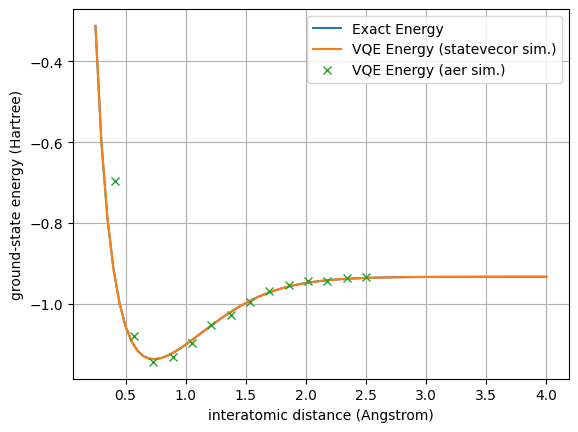

In [21]:
import matplotlib.pyplot as plt

minimum = np.argmin(np.array(vqe_energies))

print('Minimal total ground state energy: ', vqe_energies[minimum])
print('Corresponding distance: ', distances[minimum])
print(f'E_infinity: {vqe_energies[-1]} Hartree = {vqe_energies[-1]*27.2114} eV')

plt.plot(distances, exact_energies, label="Exact Energy")
plt.plot(distances, vqe_energies, label="VQE Energy (statevecor sim.)")
plt.plot(distances_aer[1:], aer_vqe_energies[1:], marker = 'x', ls = '', label="VQE Energy (aer sim.)")
plt.xlabel('interatomic distance (Angstrom)')
plt.ylabel('ground-state energy (Hartree)')
plt.legend()
plt.grid()
plt.show()


**Task:**

a) Depending on the distance between the two atoms, three different regimes can be identified. These result from the interplay of different attractive and repulsive interactions. 
Describe the three regimes and the corresponding interactions by answering the following questions.

- Why does the energy converge for large atomic distances? Interpret the obtained energy $E_{\infty}$ for large distances $d \to \infty$.
- What statement can be made about the interactions at the minimum of the curve? Which two quantities can be identified at this point? 
- What happens when the distance between the atoms approaches zero? How can the course of the energy be explained physically?

Hint: To explain the course of the curve you need to consider three interatcions: 
1. Positve-negative electrostatic interactions between the nucleus of one atom and the electron of the other ($\to$ chemical bond). 
2. Positve-positve electrostatic interactions between the nuclei. 
3. The third interaction arises from the Pauli exclusion principle.

b) Extract the value $E_{\infty}$ in eV and compare it to the literature value. Give possible reasons for the inaccuracy and explain how the accuracy could be improved.  

c) Usually, such curves are represented as molecular potentials. To obtain the molecular potential from our results, we have shift the curve upwards by adding $+ |E_{\infty}|$ such that $E \to 0$ for $d \to \infty$ and then convert the energy into eV. Plot the molecular potential (only the VQE energy from the statevector simulator) and explain what is accomplished by shifting the curve upward. What characteristic quantity of the $H_2$ molecule can now be extracted directly?

a) 
- For large distances, there is no interaction between the two atoms. The ground-state energy is just the combinded energy of the two single atoms. 
- For small distances, the interaction energy of the two electrons due to the Pauli principle increases drastically, since both are fermions an they don't "like" to be near each other
- In the minimum, there is the optimum balance between the repulsion due to the electron-electron and nucleus-nucleus interaction with the attraction due to the electron-nuclei interaction.

b) E_infinity = -0.93 Hartree. Theoretically, it should be -1 Hartree, since it's just the energy of the two atoms. The inaccuracy could be due to the chosen ansatz.

c) By shifting the curve upwards, we get the binding energy per electron which is released when two hydrogen atoms form a molecul. The minimum value gives the dissociation energy De = -5.55 eV. 

dissociation_energy: -5.549650162169802 eV


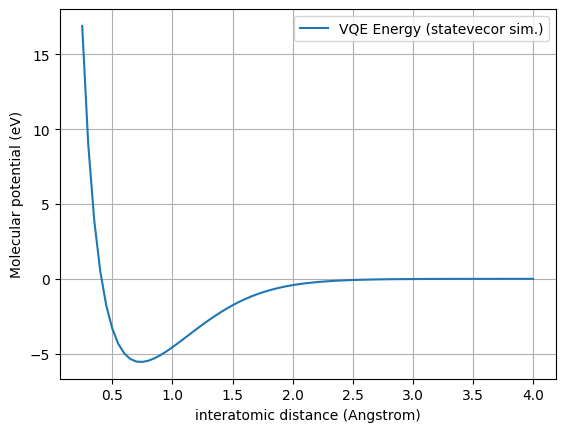

In [22]:
# Shift the curve and convert to eV
vqe_energies_converted = ( vqe_energies-vqe_energies[-1] ) * 27.2114

print(f'dissociation_energy: {vqe_energies_converted.min()} eV')

plt.plot(distances, vqe_energies_converted, label="VQE Energy (statevecor sim.)")
plt.xlabel('interatomic distance (Angstrom)')
plt.ylabel('Molecular potential (eV)')
plt.legend()
plt.grid()
plt.show()

#### 4.4 Find the correct interatomic distance

We can use the results to search for the bond length and the bond energy in a smaller range.

**Task**: 

a) Use the code from 4.2 (we use the `statevector_simulator` again to minimze the computation time) to find the minimal total ground state energy and the corresponding interatomic distance. The corresponding interatomic distance should be varied with a step size $\leq 0.002$. Plot your results for the energy over the interatomic distance.

b) Calculate the bounding energy of $\mathrm{H}_2$ (in eV) from the obtained minimal ground state energy using the value for $E_{\infty}$ from the last task (c)

c) Compare your results for the interatomic distance and the bounding energy with the literature values for $\mathrm{H}_2$. Give possible reasons for a deviation. Which of the two, bond length and bond energy, can be estimated with the version of the algorithm on hand and which one requires some changes in the algorithm?

In [23]:
import numpy as np

# Choose the statevector simulator as backend 
backend = Aer.get_backend("statevector_simulator")

# Choose an optimizer with a low number of max. iterations 
optimizer = SLSQP(maxiter=10)

# Generate the distances
distances = np.linspace(0.734, 0.736, 30)

print(f"step size {distances[1]-distances[0]:.5f}")

# Generate empty lists for the exact energies and the energis of the VQE
vqe_energies = []

for dist in distances: # loop over all distances
    # Create the Hamiltonian for the current distance
    (qubit_op, num_particles, num_spin_orbitals, problem, converter) = create_qubit_op(dist)
    
    
    # Generate the Hatree-Fock state as initial state for the VQE 
    init_state = HartreeFock(num_spin_orbitals, num_particles, converter)
    
    # Choose an Ansatz
    var_form = UCCSD(converter, num_particles, num_spin_orbitals, initial_state=init_state)
    
    # Run the VQE 
    vqe = VQE(var_form, optimizer, quantum_instance=backend)
    vqe_result = vqe.compute_minimum_eigenvalue(qubit_op)
    
    # Get the results for the total ground state energy (Hatree)
    vqe_energies.append(problem.interpret(vqe_result).total_energies[0].real)
    
    # Print the current results
    print(f"Interatomic Distance: {np.round(dist, 2)}",
          f"VQE Result: {vqe_energies[-1]:.8f}")

print("All energies have been calculated")


step size 0.00007


<ipython-input-23-a3c58ae3ae19>:29: DeprecationWarning: The class ``qiskit.algorithms.minimum_eigen_solvers.vqe.VQE`` is deprecated as of qiskit-terra 0.24.0. It will be removed no earlier than 3 months after the release date. Instead, use the class ``qiskit.algorithms.minimum_eigensolvers.VQE``. See https://qisk.it/algo_migration for a migration guide.
  vqe = VQE(var_form, optimizer, quantum_instance=backend)


Interatomic Distance: 0.73 VQE Result: -1.13730541


<ipython-input-23-a3c58ae3ae19>:29: DeprecationWarning: The class ``qiskit.algorithms.minimum_eigen_solvers.vqe.VQE`` is deprecated as of qiskit-terra 0.24.0. It will be removed no earlier than 3 months after the release date. Instead, use the class ``qiskit.algorithms.minimum_eigensolvers.VQE``. See https://qisk.it/algo_migration for a migration guide.
  vqe = VQE(var_form, optimizer, quantum_instance=backend)


Interatomic Distance: 0.73 VQE Result: -1.13730551


<ipython-input-23-a3c58ae3ae19>:29: DeprecationWarning: The class ``qiskit.algorithms.minimum_eigen_solvers.vqe.VQE`` is deprecated as of qiskit-terra 0.24.0. It will be removed no earlier than 3 months after the release date. Instead, use the class ``qiskit.algorithms.minimum_eigensolvers.VQE``. See https://qisk.it/algo_migration for a migration guide.
  vqe = VQE(var_form, optimizer, quantum_instance=backend)


Interatomic Distance: 0.73 VQE Result: -1.13730560


<ipython-input-23-a3c58ae3ae19>:29: DeprecationWarning: The class ``qiskit.algorithms.minimum_eigen_solvers.vqe.VQE`` is deprecated as of qiskit-terra 0.24.0. It will be removed no earlier than 3 months after the release date. Instead, use the class ``qiskit.algorithms.minimum_eigensolvers.VQE``. See https://qisk.it/algo_migration for a migration guide.
  vqe = VQE(var_form, optimizer, quantum_instance=backend)


Interatomic Distance: 0.73 VQE Result: -1.13730568


<ipython-input-23-a3c58ae3ae19>:29: DeprecationWarning: The class ``qiskit.algorithms.minimum_eigen_solvers.vqe.VQE`` is deprecated as of qiskit-terra 0.24.0. It will be removed no earlier than 3 months after the release date. Instead, use the class ``qiskit.algorithms.minimum_eigensolvers.VQE``. See https://qisk.it/algo_migration for a migration guide.
  vqe = VQE(var_form, optimizer, quantum_instance=backend)


Interatomic Distance: 0.73 VQE Result: -1.13730575


<ipython-input-23-a3c58ae3ae19>:29: DeprecationWarning: The class ``qiskit.algorithms.minimum_eigen_solvers.vqe.VQE`` is deprecated as of qiskit-terra 0.24.0. It will be removed no earlier than 3 months after the release date. Instead, use the class ``qiskit.algorithms.minimum_eigensolvers.VQE``. See https://qisk.it/algo_migration for a migration guide.
  vqe = VQE(var_form, optimizer, quantum_instance=backend)


Interatomic Distance: 0.73 VQE Result: -1.13730582


<ipython-input-23-a3c58ae3ae19>:29: DeprecationWarning: The class ``qiskit.algorithms.minimum_eigen_solvers.vqe.VQE`` is deprecated as of qiskit-terra 0.24.0. It will be removed no earlier than 3 months after the release date. Instead, use the class ``qiskit.algorithms.minimum_eigensolvers.VQE``. See https://qisk.it/algo_migration for a migration guide.
  vqe = VQE(var_form, optimizer, quantum_instance=backend)


Interatomic Distance: 0.73 VQE Result: -1.13730588


<ipython-input-23-a3c58ae3ae19>:29: DeprecationWarning: The class ``qiskit.algorithms.minimum_eigen_solvers.vqe.VQE`` is deprecated as of qiskit-terra 0.24.0. It will be removed no earlier than 3 months after the release date. Instead, use the class ``qiskit.algorithms.minimum_eigensolvers.VQE``. See https://qisk.it/algo_migration for a migration guide.
  vqe = VQE(var_form, optimizer, quantum_instance=backend)


Interatomic Distance: 0.73 VQE Result: -1.13730593


<ipython-input-23-a3c58ae3ae19>:29: DeprecationWarning: The class ``qiskit.algorithms.minimum_eigen_solvers.vqe.VQE`` is deprecated as of qiskit-terra 0.24.0. It will be removed no earlier than 3 months after the release date. Instead, use the class ``qiskit.algorithms.minimum_eigensolvers.VQE``. See https://qisk.it/algo_migration for a migration guide.
  vqe = VQE(var_form, optimizer, quantum_instance=backend)


Interatomic Distance: 0.73 VQE Result: -1.13730597


<ipython-input-23-a3c58ae3ae19>:29: DeprecationWarning: The class ``qiskit.algorithms.minimum_eigen_solvers.vqe.VQE`` is deprecated as of qiskit-terra 0.24.0. It will be removed no earlier than 3 months after the release date. Instead, use the class ``qiskit.algorithms.minimum_eigensolvers.VQE``. See https://qisk.it/algo_migration for a migration guide.
  vqe = VQE(var_form, optimizer, quantum_instance=backend)


Interatomic Distance: 0.73 VQE Result: -1.13730600


<ipython-input-23-a3c58ae3ae19>:29: DeprecationWarning: The class ``qiskit.algorithms.minimum_eigen_solvers.vqe.VQE`` is deprecated as of qiskit-terra 0.24.0. It will be removed no earlier than 3 months after the release date. Instead, use the class ``qiskit.algorithms.minimum_eigensolvers.VQE``. See https://qisk.it/algo_migration for a migration guide.
  vqe = VQE(var_form, optimizer, quantum_instance=backend)


Interatomic Distance: 0.73 VQE Result: -1.13730602


<ipython-input-23-a3c58ae3ae19>:29: DeprecationWarning: The class ``qiskit.algorithms.minimum_eigen_solvers.vqe.VQE`` is deprecated as of qiskit-terra 0.24.0. It will be removed no earlier than 3 months after the release date. Instead, use the class ``qiskit.algorithms.minimum_eigensolvers.VQE``. See https://qisk.it/algo_migration for a migration guide.
  vqe = VQE(var_form, optimizer, quantum_instance=backend)


Interatomic Distance: 0.73 VQE Result: -1.13730604


<ipython-input-23-a3c58ae3ae19>:29: DeprecationWarning: The class ``qiskit.algorithms.minimum_eigen_solvers.vqe.VQE`` is deprecated as of qiskit-terra 0.24.0. It will be removed no earlier than 3 months after the release date. Instead, use the class ``qiskit.algorithms.minimum_eigensolvers.VQE``. See https://qisk.it/algo_migration for a migration guide.
  vqe = VQE(var_form, optimizer, quantum_instance=backend)


Interatomic Distance: 0.73 VQE Result: -1.13730605


<ipython-input-23-a3c58ae3ae19>:29: DeprecationWarning: The class ``qiskit.algorithms.minimum_eigen_solvers.vqe.VQE`` is deprecated as of qiskit-terra 0.24.0. It will be removed no earlier than 3 months after the release date. Instead, use the class ``qiskit.algorithms.minimum_eigensolvers.VQE``. See https://qisk.it/algo_migration for a migration guide.
  vqe = VQE(var_form, optimizer, quantum_instance=backend)


Interatomic Distance: 0.73 VQE Result: -1.13730605


<ipython-input-23-a3c58ae3ae19>:29: DeprecationWarning: The class ``qiskit.algorithms.minimum_eigen_solvers.vqe.VQE`` is deprecated as of qiskit-terra 0.24.0. It will be removed no earlier than 3 months after the release date. Instead, use the class ``qiskit.algorithms.minimum_eigensolvers.VQE``. See https://qisk.it/algo_migration for a migration guide.
  vqe = VQE(var_form, optimizer, quantum_instance=backend)


Interatomic Distance: 0.73 VQE Result: -1.13730604


<ipython-input-23-a3c58ae3ae19>:29: DeprecationWarning: The class ``qiskit.algorithms.minimum_eigen_solvers.vqe.VQE`` is deprecated as of qiskit-terra 0.24.0. It will be removed no earlier than 3 months after the release date. Instead, use the class ``qiskit.algorithms.minimum_eigensolvers.VQE``. See https://qisk.it/algo_migration for a migration guide.
  vqe = VQE(var_form, optimizer, quantum_instance=backend)


Interatomic Distance: 0.74 VQE Result: -1.13730603


<ipython-input-23-a3c58ae3ae19>:29: DeprecationWarning: The class ``qiskit.algorithms.minimum_eigen_solvers.vqe.VQE`` is deprecated as of qiskit-terra 0.24.0. It will be removed no earlier than 3 months after the release date. Instead, use the class ``qiskit.algorithms.minimum_eigensolvers.VQE``. See https://qisk.it/algo_migration for a migration guide.
  vqe = VQE(var_form, optimizer, quantum_instance=backend)


Interatomic Distance: 0.74 VQE Result: -1.13730600


<ipython-input-23-a3c58ae3ae19>:29: DeprecationWarning: The class ``qiskit.algorithms.minimum_eigen_solvers.vqe.VQE`` is deprecated as of qiskit-terra 0.24.0. It will be removed no earlier than 3 months after the release date. Instead, use the class ``qiskit.algorithms.minimum_eigensolvers.VQE``. See https://qisk.it/algo_migration for a migration guide.
  vqe = VQE(var_form, optimizer, quantum_instance=backend)


Interatomic Distance: 0.74 VQE Result: -1.13730597


<ipython-input-23-a3c58ae3ae19>:29: DeprecationWarning: The class ``qiskit.algorithms.minimum_eigen_solvers.vqe.VQE`` is deprecated as of qiskit-terra 0.24.0. It will be removed no earlier than 3 months after the release date. Instead, use the class ``qiskit.algorithms.minimum_eigensolvers.VQE``. See https://qisk.it/algo_migration for a migration guide.
  vqe = VQE(var_form, optimizer, quantum_instance=backend)


Interatomic Distance: 0.74 VQE Result: -1.13730593


<ipython-input-23-a3c58ae3ae19>:29: DeprecationWarning: The class ``qiskit.algorithms.minimum_eigen_solvers.vqe.VQE`` is deprecated as of qiskit-terra 0.24.0. It will be removed no earlier than 3 months after the release date. Instead, use the class ``qiskit.algorithms.minimum_eigensolvers.VQE``. See https://qisk.it/algo_migration for a migration guide.
  vqe = VQE(var_form, optimizer, quantum_instance=backend)


Interatomic Distance: 0.74 VQE Result: -1.13730588


<ipython-input-23-a3c58ae3ae19>:29: DeprecationWarning: The class ``qiskit.algorithms.minimum_eigen_solvers.vqe.VQE`` is deprecated as of qiskit-terra 0.24.0. It will be removed no earlier than 3 months after the release date. Instead, use the class ``qiskit.algorithms.minimum_eigensolvers.VQE``. See https://qisk.it/algo_migration for a migration guide.
  vqe = VQE(var_form, optimizer, quantum_instance=backend)


Interatomic Distance: 0.74 VQE Result: -1.13730583


<ipython-input-23-a3c58ae3ae19>:29: DeprecationWarning: The class ``qiskit.algorithms.minimum_eigen_solvers.vqe.VQE`` is deprecated as of qiskit-terra 0.24.0. It will be removed no earlier than 3 months after the release date. Instead, use the class ``qiskit.algorithms.minimum_eigensolvers.VQE``. See https://qisk.it/algo_migration for a migration guide.
  vqe = VQE(var_form, optimizer, quantum_instance=backend)


Interatomic Distance: 0.74 VQE Result: -1.13730576


<ipython-input-23-a3c58ae3ae19>:29: DeprecationWarning: The class ``qiskit.algorithms.minimum_eigen_solvers.vqe.VQE`` is deprecated as of qiskit-terra 0.24.0. It will be removed no earlier than 3 months after the release date. Instead, use the class ``qiskit.algorithms.minimum_eigensolvers.VQE``. See https://qisk.it/algo_migration for a migration guide.
  vqe = VQE(var_form, optimizer, quantum_instance=backend)


Interatomic Distance: 0.74 VQE Result: -1.13730569


<ipython-input-23-a3c58ae3ae19>:29: DeprecationWarning: The class ``qiskit.algorithms.minimum_eigen_solvers.vqe.VQE`` is deprecated as of qiskit-terra 0.24.0. It will be removed no earlier than 3 months after the release date. Instead, use the class ``qiskit.algorithms.minimum_eigensolvers.VQE``. See https://qisk.it/algo_migration for a migration guide.
  vqe = VQE(var_form, optimizer, quantum_instance=backend)


Interatomic Distance: 0.74 VQE Result: -1.13730561


<ipython-input-23-a3c58ae3ae19>:29: DeprecationWarning: The class ``qiskit.algorithms.minimum_eigen_solvers.vqe.VQE`` is deprecated as of qiskit-terra 0.24.0. It will be removed no earlier than 3 months after the release date. Instead, use the class ``qiskit.algorithms.minimum_eigensolvers.VQE``. See https://qisk.it/algo_migration for a migration guide.
  vqe = VQE(var_form, optimizer, quantum_instance=backend)


Interatomic Distance: 0.74 VQE Result: -1.13730552


<ipython-input-23-a3c58ae3ae19>:29: DeprecationWarning: The class ``qiskit.algorithms.minimum_eigen_solvers.vqe.VQE`` is deprecated as of qiskit-terra 0.24.0. It will be removed no earlier than 3 months after the release date. Instead, use the class ``qiskit.algorithms.minimum_eigensolvers.VQE``. See https://qisk.it/algo_migration for a migration guide.
  vqe = VQE(var_form, optimizer, quantum_instance=backend)


Interatomic Distance: 0.74 VQE Result: -1.13730542


<ipython-input-23-a3c58ae3ae19>:29: DeprecationWarning: The class ``qiskit.algorithms.minimum_eigen_solvers.vqe.VQE`` is deprecated as of qiskit-terra 0.24.0. It will be removed no earlier than 3 months after the release date. Instead, use the class ``qiskit.algorithms.minimum_eigensolvers.VQE``. See https://qisk.it/algo_migration for a migration guide.
  vqe = VQE(var_form, optimizer, quantum_instance=backend)


Interatomic Distance: 0.74 VQE Result: -1.13730532


<ipython-input-23-a3c58ae3ae19>:29: DeprecationWarning: The class ``qiskit.algorithms.minimum_eigen_solvers.vqe.VQE`` is deprecated as of qiskit-terra 0.24.0. It will be removed no earlier than 3 months after the release date. Instead, use the class ``qiskit.algorithms.minimum_eigensolvers.VQE``. See https://qisk.it/algo_migration for a migration guide.
  vqe = VQE(var_form, optimizer, quantum_instance=backend)


Interatomic Distance: 0.74 VQE Result: -1.13730521


<ipython-input-23-a3c58ae3ae19>:29: DeprecationWarning: The class ``qiskit.algorithms.minimum_eigen_solvers.vqe.VQE`` is deprecated as of qiskit-terra 0.24.0. It will be removed no earlier than 3 months after the release date. Instead, use the class ``qiskit.algorithms.minimum_eigensolvers.VQE``. See https://qisk.it/algo_migration for a migration guide.
  vqe = VQE(var_form, optimizer, quantum_instance=backend)


Interatomic Distance: 0.74 VQE Result: -1.13730509


<ipython-input-23-a3c58ae3ae19>:29: DeprecationWarning: The class ``qiskit.algorithms.minimum_eigen_solvers.vqe.VQE`` is deprecated as of qiskit-terra 0.24.0. It will be removed no earlier than 3 months after the release date. Instead, use the class ``qiskit.algorithms.minimum_eigensolvers.VQE``. See https://qisk.it/algo_migration for a migration guide.
  vqe = VQE(var_form, optimizer, quantum_instance=backend)


Interatomic Distance: 0.74 VQE Result: -1.13730496
All energies have been calculated


bounding energy: -5.554792655288823 eV
Corresponding distance 0.734897 Angstrom


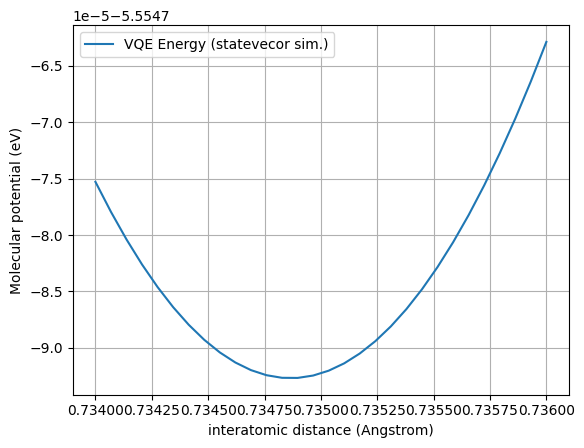

In [24]:
E_infinity = -0.9331712886000973
vqe_energies = np.array(vqe_energies)
vqe_energies_converted = ( vqe_energies-E_infinity ) * 27.2114
print(f'bounding energy: {vqe_energies_converted.min()} eV')
print(f'Corresponding distance {distances[np.argmin(vqe_energies_converted)]:.6f} Angstrom')

plt.plot(distances, vqe_energies_converted, label="VQE Energy (statevecor sim.)")
plt.xlabel('interatomic distance (Angstrom)')
plt.ylabel('Molecular potential (eV)')
plt.legend()
plt.grid()
plt.show()

### 5. Varying: Mapper, Ansatz and Optimizer

In this section we will try out different mappers, ansätze and optimisers. For this, we will write more Python functions to quickly perform the VQE for different combinations.

#### 5.1 Creating the qubit Hamiltonian for different Mappers

Besides the `JordanWignerMapper`, there are two other mappers we want to try, the `ParityMapper` and the `BravyiKiteavMapper` (see section 5.3 of the manual). First we import all mappers from qiskit.

We modify our `create_qubit_op` function, such that we can pass the different mappers as an argument.


In [25]:
from qiskit_nature.mappers.second_quantization import JordanWignerMapper, ParityMapper, BravyiKitaevMapper

def create_qubit_op(dist,mappertype='JordanWignerMapper'):
    '''
    Input: 
        dist: interatomic distance of the H atoms (float)
        mapper: name of the mapper (str) 
            possible mappers: JordanWignerMapper, ParityMapper, BravyiKitaevMapper
    Output:
        qubit_op: Hamiltonian mapped onto the qubits
        num_particles: total number of electrons
        num_spin_orbitals: total number of spin orbitals
        problem: corresponding ElectronicStructureProblem object
        converter: QubitConverter object
    '''
    
    # Define the molecule for the given distance 
    molecule = Molecule(
    # Coordinates in Angstrom 
    geometry= [
        ["H", [0.0,0.0,0.0]], 
        ["H", [0.0,0.0,dist]]
    ]    
    )

    # Define the driver 
    driver = ElectronicStructureMoleculeDriver(
        molecule=molecule,
        basis="sto3g",
        driver_type = ElectronicStructureDriverType.PYSCF
    )

    # Run the driver
    properties = driver.run()

    # Get additional properties
    num_particles = (properties.get_property("ParticleNumber").num_particles)
    num_spin_orbitals = int(properties.get_property("ParticleNumber").num_spin_orbitals)

    # Define the problem using the driver
    problem = ElectronicStructureProblem(driver)

    # Generate the second-quantized operators
    second_q_ops = problem.second_q_ops()

    # Get the Hamiltonian
    hamiltonian = second_q_ops['ElectronicEnergy']

    # Set the mapper
    if mappertype == 'JordanWignerMapper':
        mapper = JordanWignerMapper()
    elif mappertype == 'ParityMapper':
        mapper = ParityMapper()
    elif mappertype == 'BravyiKitaevMapper':
        mapper =  BravyiKitaevMapper()
    else:
        print('No mapper found with the name: ', mappertype)
        return 
        
    # Set the converter without two qubit reduction
    converter = QubitConverter(mapper = mapper, two_qubit_reduction = False)

    # Map the fermionic operators onto qubit operators 
    num_particles = problem.num_particles
    qubit_op = converter.convert(hamiltonian, num_particles=num_particles)
    
    
    return qubit_op, num_particles, num_spin_orbitals, problem, converter

#### 5.2 Using a different Ansatz and Optimizer

First we load some of the other Ansatzes, which are availabe in qiskit. More Ansatzes can be found [here](https://qiskit.org/documentation/nature/apidocs/qiskit_nature.circuit.library.html). We want to stick with the ones presented in section 5.4.2 of the manual.

In [26]:
from qiskit.circuit.library import TwoLocal, EfficientSU2 
from qiskit_nature.circuit.library import UCCSD, PUCCD, SUCCD

We also load more optimizers to try. 
A full list of the supported optimizers can be found [here](https://qiskit.org/documentation/stubs/qiskit.algorithms.optimizers.html). Here, we also want to stick with those presented in the manual (see section 5.4.3).

In [27]:
from qiskit.algorithms.optimizers import COBYLA, SPSA, SLSQP, L_BFGS_B

To vary the ansatz and the optimizer, we write another Python function that loads the backend and performs the VQE. The function should have the following input arguments: 

- necessary data for the VQE
- type of the simulator
- Ansatz
- optimizer

The function shall return the result of the VQE and the two lists for the convergence.

Note, that the `TwoLocal` ansatz (and the `EfficientSU2` ansatz) needs more configuration. 

In [28]:
def run_vqe(qubit_op, num_particles, num_spin_orbitals, problem, converter, 
            simulator_type ='aer_simulator', ansatz_type='UCCSD', optimizer_type='SPSA', max_iterations = 100,
            entanglement = 'full', rotation_blocks = ['rx', 'ry'], entanglement_blocks = ['cz']):
    '''
    Possible inputs:
    - simulator_type = 'aer_simulator', 'statevector_simulator'
    - ansatz_type = 'UCCSD', 'PUCDD', 'SUCCD', 'EfficientSU2', 'TwoLocal'
    - optimizer_type = 'COBYLA', 'SPSA', 'SLSQP', 'L_BFGS_B'
    - entanglement = 'linear', 'full', 'circular'
    - rotation_blocks: list of 'rx', 'ry', 'rz'
    - entanglement_blocks: 'cx', 'cz'
    '''
    
    # Load the simulator
    try:
        backend = Aer.get_backend(simulator_type)
        # Generate a QuantumInstance
        qi = QuantumInstance(backend=backend)
    except:
        print('Simualtor: ', simulator_type, 'not found!')
        return
    
    
    # Set up the TwoLocal ansatz   
    
    # Repetitions of rotation_blocks + entanglement_blocks with independent parameters
    repetitions = 3
    # Skip the final rotation_blocks layer
    skip_final_rotation_layer = False
    
    # Get the initiale state for the other ansatzes
    init_state = HartreeFock(num_spin_orbitals, num_particles, converter) 

    # Define the Ansatz
     
    if ansatz_type == 'TwoLocal':    
        ansatz = TwoLocal(qubit_op.num_qubits, rotation_blocks, entanglement_blocks, reps=repetitions, 
                      entanglement=entanglement, skip_final_rotation_layer=skip_final_rotation_layer)   
    elif ansatz_type == 'UCCSD':
        ansatz = UCCSD(converter, num_particles, num_spin_orbitals,initial_state=init_state)
    elif ansatz_type == 'PUCCD':
        ansatz = PUCCD(converter, num_particles, num_spin_orbitals,initial_state=init_state)
    elif ansatz_type == 'SUCCD':
        ansatz = SUCCD(converter, num_particles, num_spin_orbitals,initial_state=init_state)    
    elif ansatz_type == 'EfficientSU2':
        ansatz = EfficientSU2(qubit_op.num_qubits, entanglement=entanglement)
    else:
        print('Ansatz ', ansatz_type, ' not found!')
        return
    
    # Define the optimizer
    if optimizer_type == 'COBYLA':
        optimizer = COBYLA(maxiter=max_iterations)
    elif optimizer_type == 'L_BFGS_B':
        optimizer = L_BFGS_B(maxiter=max_iterations)
    elif optimizer_type == 'SPSA':
        optimizer = SPSA(maxiter=max_iterations)
    elif optimizer_type == 'SLSQP':
        optimizer = SLSQP(maxiter=max_iterations)

    # Run the VQE using the quantum instance and the callback function
    vqe = VQE(ansatz, optimizer=optimizer, quantum_instance=qi)
    vqe_result = vqe.compute_minimum_eigenvalue(operator=qubit_op)

    return vqe_result, ansatz

#### 5.3 Storing the results in a dictionary

We now want to write a rotine that performs the VQE using the functions defined above, evaluates the result and stores it in a dictionary. 
Using the pandas package, we can then save the data in a .csv file and display it clearly. The rotine can be used to easily test and evaluate different combinations of mapper, Ansatz and optimizer.

In order to judge how good the choise of the ansatz/optimizer is, one can use the number of CNOT-gates of the ansatz. However, one also wants to reach chemical accuracy, which is $\Delta E_{\text{chem}} = 4 \text{mHa}$. This is hard to reach, depending on the problem. 
While its easy to achieve low numbers of CNOT gates, while reaching accuacies far below $\Delta E_{\text{chem}}$ for $\text{H}_2$, it gets quickly impossible for larger molecules.
The rotine below gives you the number of CNOTs for your choise of mapper, ansatz and optimizer, as well as the error $\Delta E$ and the run time of the calculation.

In [29]:
# Import more required packages

import pandas as pd
import os.path
import matplotlib.pyplot as plt

import timeit

from qiskit.transpiler import PassManager
from qiskit.transpiler.passes import Unroller

In [31]:
def add_to_file(mapper = 'ParityMapper',
                ansatz = 'PUCCD',
                optimizer = 'COBYLA',
                entanglement = 'linear',
                rotation_blocks = ['rx', 'ry', 'rz'],
                entanglement_blocks = ['cz'],
                max_iterations = 10
                ):

    ### Choose the mapper, the ansatz and the optimizer

    # mapper = 'ParityMapper'
    # 'JordanWignerMapper', 'ParityMapper', 'BravyiKitaevMapper'

    # ansatz = 'PUCCD'
    # 'UCCSD', 'PUCCD', 'SUCCD', 'EfficientSU2', 'TwoLocal'

    # optimizer = 'COBYLA'
    # 'COBYLA', 'SPSA', 'SLSQP', 'L_BFGS_B'
    # max_iterations = 10

    ### Set the parameters of the TwoLocal and the EfficientSU2 Ansatz 

    # entanglement = 'linear' 
    # 'linear', 'full', 'circular'
    # rotation_blocks = ['rx', 'ry', 'rz']
    # 'rx', 'ry', 'rz'
    #entanglement_blocks = ['cz']
    # 'cz', 'cx'

    ### Perform the VQE 

    # Time the computation 
    start = timeit.default_timer()

    # Generate the qubit Hamiltonian
    (qubit_op, num_particles, num_spin_orbitals, problem, converter) = create_qubit_op(dist = 0.735,mappertype=mapper)

    # Perform the VQE and observe the convergence 
    (vqe_result, ansatz_circuit) = run_vqe(qubit_op, num_particles, num_spin_orbitals, problem, converter, 
                simulator_type = 'aer_simulator', ansatz_type=ansatz, optimizer_type=optimizer, max_iterations = max_iterations,
                entanglement=entanglement, rotation_blocks=rotation_blocks, entanglement_blocks=entanglement_blocks)

    stop = timeit.default_timer()

    ### Calculate the exact energy 

    exact_result = exact_solver(problem,converter)


    ### Get the number of required CNOTS

    # Use an Unroller to transpile the used circuit into CNOTs and U gates to count them
    pass_ = Unroller(['u', 'cx'])
    pass_manager = PassManager(pass_)
    ansatz_tp = pass_manager.run(ansatz_circuit)
    n_cnots = ansatz_tp.count_ops()['cx']

    
    ### Gnerate the result dictinoary

    if ansatz == 'TwoLocal':
        result_dict = {
            'mapper': mapper,
            'optimizer': optimizer, 
            'max iterations': max_iterations,
            'ansatz': ansatz,
            'entanglement': entanglement,
            'rotation blocks': rotation_blocks,
            'entanglement blocks': entanglement_blocks,
            'electronic gs-energy VQE (Ha)': vqe_result.optimal_value,
            'electronic gs-energy error (mHa)': abs(exact_result.eigenenergies[0] - vqe_result.optimal_value)/1000,
            'total gs-energy VQE (Ha)):': problem.interpret(vqe_result).total_energies[0].real,
            'total gs-energy error (mHa)': abs(exact_result.total_energies[0].real - problem.interpret(vqe_result).total_energies[0].real)/1000,
            '# of parameters': len(vqe_result.optimal_point),
            'optimizer time': vqe_result.optimizer_time,
            '# of qubits': int(qubit_op.num_qubits),
            '# of CNOTs': n_cnots,
            'runtime': stop - start
        }
    elif ansatz == 'EfficientSU2"':
        result_dict = {
            'mapper': mapper,
            'optimizer': optimizer, 
            'max iterations': max_iterations,
            'ansatz': ansatz,
            'entanglement': entanglement,
            'rotation blocks': None,
            'entanglement blocks': None,
            'electronic gs-energy VQE (Ha)': vqe_result.optimal_value,
            'electronic gs-energy error (mHa)': abs(exact_result.eigenenergies[0] - vqe_result.optimal_value)/1000,
            'total gs-energy VQE (Ha)):': problem.interpret(vqe_result).total_energies[0].real,
            'total gs-energy error (mHa)': abs(exact_result.total_energies[0].real - problem.interpret(vqe_result).total_energies[0].real)/1000,
            '# of parameters': len(vqe_result.optimal_point),
            'optimizer time': vqe_rer
        }
    else:    
        result_dict = {
            'mapper': mapper,
            'optimizer': optimizer, 
            'ansatz': ansatz,
            'max iterations': max_iterations,
            'entanglement': None,
            'rotation blocks': None,
            'entanglement blocks': None,
            'electronic gs-energy VQE (Ha)': vqe_result.optimal_value,
            'electronic gs-energy error (mHa)': abs(exact_result.eigenenergies[0] - vqe_result.optimal_value)*1000,
            'total gs-energy VQE (Ha)):': problem.interpret(vqe_result).total_energies[0].real,
            'total gs-energy error (mHa)': abs(exact_result.total_energies[0].real - problem.interpret(vqe_result).total_energies[0].real)*1000,
            '# of parameters': len(vqe_result.optimal_point),
            'optimizer time': vqe_result.optimizer_time,
            '# of qubits': int(qubit_op.num_qubits),
            '# of CNOTs': n_cnots,
            'runtime': stop - start
        }


    ### Display and save the data 

    file = 'results_h2.csv'

    # Append the result dictinoary to the savefile
    if os.path.isfile(file):
        # Get the data frame from the savefile and append the new data
        results_df = pd.read_csv(file)
        result_dict = pd.DataFrame.from_dict([result_dict])
        results_df = pd.concat([results_df, result_dict],ignore_index = True)
    else:
        # Create a new data frame 
        results_df = pd.DataFrame.from_dict([result_dict])
    # Store the data frame 
    results_df.to_csv(file)

    return results_df

# Show the data 
#results_df[['mapper', 'optimizer', 'ansatz', 'entanglement', 'rotation blocks', 'entanglement blocks',
#            'electronic gs-energy VQE (Ha)', 'electronic gs-energy error (mHa)',
#            '# of parameters', 'optimizer time', '# of qubits', '# of CNOTs', 'runtime']]


**Task**:

Use the rotine above to try out different combinations for the mapper, the Ansatz and the optimizer. Try to minimize the error while using as less CNOT-gates as possible. Note, that your results will get stored automatically into the `results_h2.csv` file and will be displayed above in addition.

In [34]:
mapper_ = ['JordanWignerMapper', 'ParityMapper', 'BravyiKitaevMapper']

ansatz_ = ['UCCSD', 'PUCCD', 'SUCCD', 'EfficientSU2', 'TwoLocal']

optimizer_ = ['COBYLA', 'SPSA', 'SLSQP', 'L_BFGS_B']

### Set the parameters of the TwoLocal and the EfficientSU2 Ansatz 

# entanglement = 'linear' 
entanglement_ = ['linear', 'full', 'circular']
# rotation_blocks = ['rx', 'ry', 'rz']
# 'rx', 'ry', 'rz'
#entanglement_blocks = ['cz']
entanglement_blocks_ = ['cz', 'cx']

for mapper in mapper_:
    for optimizer in optimizer_:
        for ansatz in ansatz_:
            if ansatz == 'EfficientSU2':
                for entanglement in entanglement_:
                    results_df = add_to_file(mapper=mapper, ansatz=ansatz, optimizer=optimizer, entanglement=entanglement)
            elif ansatz == 'TwoLocal':
                for entanglement in entanglement_:
                    for entanglement_blocks in entanglement_blocks_:
                        results_df = add_to_file(mapper=mapper, ansatz=ansatz, optimizer=optimizer, entanglement=entanglement, entanglement_blocks=entanglement_blocks)
            else: 
                results_df = add_to_file(mapper=mapper, ansatz=ansatz, optimizer=optimizer)
         

<ipython-input-28-37de59fbc161>:18: DeprecationWarning: The class ``qiskit.utils.quantum_instance.QuantumInstance`` is deprecated as of qiskit-terra 0.24.0. It will be removed no earlier than 3 months after the release date. For code migration guidelines, visit https://qisk.it/qi_migration.
  qi = QuantumInstance(backend=backend)
<ipython-input-28-37de59fbc161>:62: DeprecationWarning: The class ``qiskit.algorithms.minimum_eigen_solvers.vqe.VQE`` is deprecated as of qiskit-terra 0.24.0. It will be removed no earlier than 3 months after the release date. Instead, use the class ``qiskit.algorithms.minimum_eigensolvers.VQE``. See https://qisk.it/algo_migration for a migration guide.
  vqe = VQE(ansatz, optimizer=optimizer, quantum_instance=qi)
<ipython-input-28-37de59fbc161>:18: DeprecationWarning: The class ``qiskit.utils.quantum_instance.QuantumInstance`` is deprecated as of qiskit-terra 0.24.0. It will be removed no earlier than 3 months after the release date. For code migration guidel

KeyboardInterrupt: ignored

In [46]:
from google.colab import drive
drive.mount('/content/drive')
file = '/content/drive/MyDrive/FP/results_h2.csv'
# file = "results_h2.csv"
# for google colab, for local adjust the file location

results_df = pd.read_csv(file)
results_df[['mapper', 'optimizer', 'ansatz', 'entanglement', 'rotation blocks', 'entanglement blocks',
            'electronic gs-energy VQE (Ha)', 'electronic gs-energy error (mHa)',
            '# of parameters', 'optimizer time', '# of qubits', '# of CNOTs', 'runtime']].sort_values("electronic gs-energy error (mHa)")


Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


,mapper,optimizer,ansatz,entanglement,rotation blocks,entanglement blocks,electronic gs-energy VQE (Ha),electronic gs-energy error (mHa),# of parameters,optimizer time,# of qubits,# of CNOTs,runtime
8,JordanWignerMapper,COBYLA,TwoLocal,full,"['rx', 'ry', 'rz']",cz,-1.288969,0.000568,48,0.698315,4,18,0.959292
59,ParityMapper,COBYLA,TwoLocal,circular,"['rx', 'ry', 'rz']",cx,-1.220512,0.000637,48,0.488881,4,12,0.723795
6,JordanWignerMapper,COBYLA,TwoLocal,linear,"['rx', 'ry', 'rz']",cz,-1.204515,0.000653,48,0.671409,4,9,0.943687
129,BravyiKitaevMapper,SLSQP,TwoLocal,full,"['rx', 'ry', 'rz']",cx,-1.199130,0.000658,48,25.138433,4,18,25.380978
115,BravyiKitaevMapper,SPSA,TwoLocal,linear,"['rx', 'ry', 'rz']",cx,-1.099908,0.000757,48,3.043539,4,9,3.286350
...,...,...,...,...,...,...,...,...,...,...,...,...,...
28,JordanWignerMapper,SLSQP,EfficientSU2,NaN,NaN,NaN,-0.692007,1165.267778,32,1.797873,4,18,2.055233
26,JordanWignerMapper,SLSQP,SUCCD,NaN,NaN,NaN,-0.337390,1519.885053,1,3.559185,4,48,3.821133
74,ParityMapper,SLSQP,SUCCD,NaN,NaN,NaN,-0.319847,1537.428266,1,2.233772,4,32,2.460384
73,ParityMapper,SLSQP,PUCCD,NaN,NaN,NaN,-0.272286,1584.989472,1,1.753726,4,32,1.982290


The lowest error was found with JordanWignerMapper,	COBYLA optimizer,	TwoLocal ansatz,	full entanglement and cz blocks.
Almost the same error but with half the CNOT gates was found with linear entanglement.

#### 5.4: Helper - import everything

If you have closed the notebook or restared the kernel, than you need to reimport the required packeges. In order to avoid going trough the whole notebook again, you can run the fowlloing code.

In [33]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import os.path
import timeit

from qiskit_nature.drivers import Molecule
from qiskit_nature.drivers.second_quantization import (
    ElectronicStructureMoleculeDriver, ElectronicStructureDriverType)
from qiskit_nature.problems.second_quantization import ElectronicStructureProblem

from qiskit_nature.mappers.second_quantization import JordanWignerMapper, ParityMapper, BravyiKitaevMapper
from qiskit_nature.converters.second_quantization import QubitConverter

from qiskit_nature.circuit.library import HartreeFock
from qiskit.circuit.library import TwoLocal, EfficientSU2 
from qiskit_nature.circuit.library import UCCSD, PUCCD, SUCCD

from qiskit.algorithms.optimizers import COBYLA, SPSA, SLSQP, L_BFGS_B

from qiskit.transpiler import PassManager
from qiskit.transpiler.passes import Unroller

from qiskit.algorithms import VQE

from qiskit import Aer
from qiskit.providers.aer import QasmSimulator
from qiskit.utils import QuantumInstance


from qiskit_nature.algorithms import (GroundStateEigensolver,
                                      NumPyMinimumEigensolverFactory)

def exact_solver(problem, converter):
    solver = NumPyMinimumEigensolverFactory()
    calc = GroundStateEigensolver(converter, solver)
    result = calc.solve(problem)
    return result

## Part 2: VQE for LiH

### 2.1 Import required packaes and build functions

We start off with importing all required packages and define similiar funtions as used in part 1.

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import os.path
import timeit

# Import the driver and problem
from qiskit_nature.drivers import Molecule
from qiskit_nature.drivers.second_quantization import (
    ElectronicStructureMoleculeDriver, ElectronicStructureDriverType)
from qiskit_nature.problems.second_quantization import ElectronicStructureProblem

# Import the FreezeCoreTransformer
from qiskit_nature.transformers.second_quantization.electronic import FreezeCoreTransformer

# Import the mappers
from qiskit_nature.mappers.second_quantization import JordanWignerMapper, ParityMapper, BravyiKitaevMapper
from qiskit_nature.converters.second_quantization import QubitConverter

# Import the ansatzes
from qiskit_nature.circuit.library import HartreeFock
from qiskit.circuit.library import TwoLocal, EfficientSU2 
from qiskit_nature.circuit.library import UCCSD, PUCCD, SUCCD

# Import the optimizer
from qiskit.algorithms.optimizers import COBYLA, SPSA, SLSQP, L_BFGS_B

# Import the unroller
from qiskit.transpiler import PassManager
from qiskit.transpiler.passes import Unroller

# Import thq VQE
from qiskit.algorithms import VQE

# Import Aer
from qiskit import Aer
from qiskit.providers.aer import QasmSimulator
from qiskit.utils import QuantumInstance

# Import the exact solver
from qiskit_nature.algorithms import (GroundStateEigensolver,
                                      NumPyMinimumEigensolverFactory)

/tmp/ipykernel_23705/3575495753.py:41: NatureDeprecationWarning: The qiskit_nature.algorithms.excited_state_solvers package is deprecated as of version 0.5.0 and will be removed no sooner than 3 months after the release. Instead use the qiskit_nature.second_q.algorithms.excited_state_solvers package.
  from qiskit_nature.algorithms import (GroundStateEigensolver,
/tmp/ipykernel_23705/3575495753.py:41: NatureDeprecationWarning: The qiskit_nature.algorithms.pes_sampler package is deprecated as of version 0.5.0 and will be removed no sooner than 3 months after the release . Please refer to 'https://github.com/Qiskit/qiskit-nature/issues/750' for additional information regarding 'extrapolators'.
  from qiskit_nature.algorithms import (GroundStateEigensolver,


In [2]:
def exact_solver(problem, converter):
    '''
    Calcualtes the exact solution to a given problem and converter.
    '''
    solver = NumPyMinimumEigensolverFactory()
    calc = GroundStateEigensolver(converter, solver)
    result = calc.solve(problem)
    return result


def create_qubit_op_lih(dist,mappertype='JordanWignerMapper',reduce=False):
    '''
    Creates the second quantization Hamilton operator for the LiH molecule for a 
    given interatomic distance and mapps it onto qubits using a given mapper.
    
    Input: 
        dist: interatomic distance of the atoms (float)
        mapper: name of the mapper (str) 
            possible mappers: JordanWignerMapper, ParityMapper, BravyiKitaevMapper
        reduce: boolean to apply the freeze core approximation and to remove 
        some orbitals
    Output:
        qubit_op: Hamiltonian mapped onto the qubits
        num_particles: total number of electrons
        num_spin_orbitals: total number of spin orbitals
        problem: corresponding ElectronicStructureProblem object
        converter: QubitConverter object
    '''
    
    # Define the molecule for the given distance 
    molecule = Molecule(
    # Coordinates in Angstrom 
    geometry= [
        ["Li", [0.0,0.0,0.0]], 
        ["H", [0.0,0.0,dist]]],
        multiplicity=1,  # = 2*spin + 1
        charge=0, 
    )

    # Define the driver 
    driver = ElectronicStructureMoleculeDriver(
        molecule=molecule,
        basis="sto3g",
        driver_type = ElectronicStructureDriverType.PYSCF
    )

    # Run the driver
    properties = driver.run()

    # Define the problem using the driver
    if reduce:
        # Remove the core orbitals and the unoccupied orbitals
        problem = ElectronicStructureProblem(
            driver,
            [FreezeCoreTransformer(freeze_core=True,
                                   remove_orbitals=[-3,-2])]
        )
    else:
        problem = ElectronicStructureProblem(driver)
    
    # Generate the second-quantized operators
    second_q_ops = problem.second_q_ops()
    
    # Get additional properties
    num_particles = problem.num_particles
    num_spin_orbitals = problem.num_spin_orbitals

    # Get the Hamiltonian
    hamiltonian = second_q_ops['ElectronicEnergy']

    # Set the mapper
    if mappertype == 'JordanWignerMapper':
        mapper = JordanWignerMapper()
    elif mappertype == 'ParityMapper':
        mapper = ParityMapper()
    elif mappertype == 'BravyiKitaevMapper':
        mapper =  BravyiKitaevMapper()
    else:
        print('No mapper found with the name: ', mappertype)
        return 
        
    # Set the converter without two qubit reduction
    converter = QubitConverter(mapper = mapper, two_qubit_reduction = False)

    # Map the fermionic operators onto qubit operators 
    num_particles = problem.num_particles
    qubit_op = converter.convert(hamiltonian, num_particles=num_particles)
    
    
    return qubit_op, num_particles, num_spin_orbitals, problem, converter


def run_vqe(qubit_op, num_particles, num_spin_orbitals, problem, converter, 
            simulator_type ='aer_simulator', ansatz_type='UCCSD', 
            optimizer_type='SPSA', max_iterations = 100,
            entanglement = 'full', rotation_blocks = ['rx', 'ry'], 
            entanglement_blocks = ['cz']):
    '''
    Performs the VQE for a given qubit Hamiltonian (including the corresponding 
    number of particles and orbitales, the problem and the converter) using
    different simualtors, ansatzes and optimizers. The convergence is monitored
    as well.
    
    Input:
    qubit_op: Appropriate qubit operator
    num_particles: number of electrons
    num_spin_orbitales: number of spin orbitales
    problem: electronic structure problem
    converter: qubit converter
    Optional Input:
    simulator_type: 'aer_simulator', 'statevector_simulator'
    ansatz_type:'UCCSD', 'PUCDD', 'SUCCD', 'EfficientSU2', 'TwoLocal'
    optimizer_type: 'COBYLA', 'SPSA', 'SLSQP', 'L_BFGS_B'
    ntanglement: 'linear', 'full', 'circular'
    rotation_blocks: list of 'rx', 'ry', 'rz'
    entanglement_blocks: 'cx', 'cz'
    
    Output:
    vqe_result: result of the VQE 
    counts: list of the evaluation counts 
    values: list of the energy values for each evaluation
    ansatz: the used ansatz object
    '''
    
    # Load the simulator
    try:
        backend = Aer.get_backend(simulator_type)
        # Generate a QuantumInstance
        qi = QuantumInstance(backend=backend)
    except:
        print('Simualtor: ', simulator_type, 'not found!')
        return
    
    
    # Set up the TwoLocal ansatz   
    
    # Repetitions of rotation_blocks + entanglement_blocks with independent parameters
    repetitions = 3
    # Skip the final rotation_blocks layer
    skip_final_rotation_layer = False
    
    # Get the initiale state for the other ansatzes
    init_state = HartreeFock(num_spin_orbitals, num_particles, converter) 

    # Define the Ansatz
    if ansatz_type == 'TwoLocal':    
        ansatz = TwoLocal(qubit_op.num_qubits, rotation_blocks, entanglement_blocks, reps=repetitions, 
                      entanglement=entanglement, skip_final_rotation_layer=skip_final_rotation_layer)   
    elif ansatz_type == 'UCCSD':
        ansatz = UCCSD(converter, num_particles, num_spin_orbitals,initial_state=init_state)
    elif ansatz_type == 'PUCCD':
        ansatz = PUCCD(converter, num_particles, num_spin_orbitals,initial_state=init_state)
    elif ansatz_type == 'SUCCD':
        ansatz = SUCCD(converter, num_particles, num_spin_orbitals,initial_state=init_state)    
    elif ansatz_type == 'EfficientSU2':
        ansatz = EfficientSU2(qubit_op.num_qubits, entanglement=entanglement)
    else:
        print('Ansatz ', ansatz_type, ' not found!')
        return
    
    # Define the optimizer
    if optimizer_type == 'COBYLA':
        optimizer = COBYLA(maxiter=max_iterations)
    elif optimizer_type == 'L_BFGS_B':
        optimizer = L_BFGS_B(maxiter=max_iterations)
    elif optimizer_type == 'SPSA':
        optimizer = SPSA(maxiter=max_iterations)
    elif optimizer_type == 'SLSQP':
        optimizer = SLSQP(maxiter=max_iterations)

    # Run the VQE using the quantum instance and the callback function
    vqe = VQE(ansatz, optimizer=optimizer, quantum_instance=qi)
    vqe_result = vqe.compute_minimum_eigenvalue(operator=qubit_op)

    return vqe_result, ansatz


def eval_vqe_result(vqe_result,problem,converter):
    
    # Get the VQE results     
    vqe_electronic_ground_state = vqe_result.optimal_value
    print('Electronic ground state energy (Ha): ', vqe_electronic_ground_state)

    vqe_total_ground_state = problem.interpret(vqe_result).total_energies[0].real
    print('Total ground state energy (Ha): ', vqe_total_ground_state)
    
    # Get the exact results
    result_exact = exact_solver(problem,converter)

    exact_electronic_ground_state = result_exact.eigenenergies[0]
    print('Exact electronic ground state energy (Ha): ', exact_electronic_ground_state)

    exact_total_ground_state = result_exact.total_energies[0].real
    print('Exact: total ground state energy (Ha): ',exact_total_ground_state)
    
    # Calculate the deviation
    error_electronic = abs(exact_electronic_ground_state - vqe_electronic_ground_state)*1000
    print('Error for the electrontic ground state (mHa): ', error_electronic)

### 2.2 Run a simualtion with and without reduction

To avoid very long calculation times, we again use the `statevector_simulator` for LiH, which is much faster than the `aer_simulator` and gives good results in the case of LiH without oversimplifying (as in the case of $\text{H}_2$).

#### 2.2.1 Without reduction

**Task**:

Use the functions above to to determine the electronic ground state energy of $\mathrm{LiH}$, as well as the total ground state energy and the deviation from the exact value for a interatomic distance of 1.0 Angstrom. 
Use the Jordan-Wigner mapper, the UCCSD ansatz and the SLSQP optimizer. Limit the number of maximal iterations to 5 and set the input argument `reduce` to `False`. 

In [ ]:
dist = 1.0
qubit_op, num_particles, num_spin_orbitals, problem, converter = create_qubit_op_lih(dist,mappertype='JordanWignerMapper',reduce=False)
print(num_particles, num_spin_orbitals)
vqe_result, ansatz = run_vqe(qubit_op, num_particles, num_spin_orbitals, problem, converter, 
                              simulator_type ='statevector_simulator', ansatz_type='UCCSD', 
                              optimizer_type='SLSQP', max_iterations = 5,
                              entanglement = 'full', rotation_blocks = ['rx', 'ry'], 
                              entanglement_blocks = ['cz'])
print(vqe_result, ansatz)
eval_vqe_result(vqe_result,problem,converter)

/tmp/ipykernel_23705/1356920191.py:2: NatureDeprecationWarning: The qiskit_nature.drivers.Molecule class is deprecated as of version 0.5.0 and will be removed no sooner than 3 months after the release. Instead use the qiskit_nature.second_q.drivers.Molecule class.
  qubit_op, num_particles, num_spin_orbitals, problem, converter = create_qubit_op_lih(dist,mappertype='JordanWignerMapper',reduce=False)
/tmp/ipykernel_23705/1356920191.py:2: NatureDeprecationWarning: The qiskit_nature.problems.second_quantization.electronic.ElectronicStructureProblem class is deprecated as of version 0.5.0 and will be removed no sooner than 3 months after the release. Instead use the qiskit_nature.second_q.problems.ElectronicStructureProblem class.
  qubit_op, num_particles, num_spin_orbitals, problem, converter = create_qubit_op_lih(dist,mappertype='JordanWignerMapper',reduce=False)


(2, 2) 12
{   'aux_operator_eigenvalues': None,
    'cost_function_evals': 469,
    'eigenstate': array([ 2.50992803e-17-4.98732999e-18j,  4.78387546e-17+4.85862351e-17j,
        1.09438818e-16-4.11497621e-17j, ...,
       -1.74891296e-19-4.55196312e-20j, -1.77665161e-19+1.80581236e-19j,
        1.94057435e-19-1.98848991e-19j]),
    'eigenvalue': (-9.3716782924479+0j),
    'optimal_circuit': None,
    'optimal_parameters': {   ParameterVectorElement(t[4]): -0.002921592728024041,
                              ParameterVectorElement(t[6]): 1.5658548816356015e-07,
                              ParameterVectorElement(t[5]): -3.9393462724468387e-07,
                              ParameterVectorElement(t[3]): 0.0006007553968895132,
                              ParameterVectorElement(t[2]): -3.566102223333605e-07,
                              ParameterVectorElement(t[1]): -2.68220182938072e-07,
                              ParameterVectorElement(t[7]): 0.0005990379765141332,
              

/tmp/ipykernel_23705/2348905665.py:6: NatureDeprecationWarning: The qiskit_nature.algorithms.ground_state_solvers.GroundStateEigensolver class is deprecated as of version 0.5.0 and will be removed no sooner than 3 months after the release. Instead use the qiskit_nature.second_q.algorithms.ground_state_solvers.GroundStateEigensolver class.
  calc = GroundStateEigensolver(converter, solver)


We observe extremely long calculation times ($\geq$ 5 min. for one calculation with only `max_iter = 5`). This is inconvenient for our further calculations and therefore we want to reduce the problem.

#### 2.2.2 With reduction

To simplify the problem and speed up the calculation we can use the `FreezeCoreTransformer` from Qiskit. This is already built into the function for creating the qubit operator above and can be activated with `reduce = True`. 
If enabled, the core orbitals are automatically determined and removed from the calculation. In addition, unoccupied orbitals can optionally be removed manually (see section 5.5.2 of the manual). Let's take a look at the orbitals.

In [ ]:
# Define the molecule for the given distance 
molecule = Molecule(
# Coordinates in Angstrom 
geometry= [
    ["Li", [0.0,0.0,0.0]], 
    ["H", [0.0,0.0,1.0]]],
    multiplicity=1,  # = 2*spin + 1
    charge=0, 
)

# Define the driver 
driver = ElectronicStructureMoleculeDriver(
    molecule=molecule,
    basis="sto3g",
    driver_type = ElectronicStructureDriverType.PYSCF
)

# Run the driver
properties = driver.run()

print(properties.get_property("ParticleNumber"))


We find 12 orbitals, which explains the longer computation times compared to $\mathrm{H}_2$. We can remove some of the orbitals using the `FreezeCoreTransformer`, which is already build into the function `create_qubit_op_lih` above. You can enable it, by changing the input agrument `reduce` to `True`. As you can see in the function, two orbitals are removed manually. In addition the core orbitals are also not taken into accout.

**Task**: 

a) Explain why you don't have to consider the core orbitals in the calculation and why you can even remove two more orbitals manually. 

b) How many orbitals are left for the calculation when using the Jordan Wigner mapping? Name a way to reduce the number of orbitals even further.

c) Modify the code from the last task to reduce the number of orbitals by setting the input argument `reduce` of the `create_qubit_op_lih` to `True` and run the code again. What do you observe?

The calculation time has improved significantly. Therefore, we reduce the problem for all further calculations.

### 2.3 Varying interatomic distance

Next we want to find the correct interatomic distance. We perform the calculation analogous to $\text{H}_2$, but here we reduce the number of orbitals. We stick with the `statevector_simulator`. 

**Task**: 

a) Use the functions from 2.1 to calculate the total ground state energy of $\mathrm{LiH}$ for various distances and plot your results. Determine the bond length and compare your results with the literature value. 

Note that the code may take a few minutes to run to completion. To cap the computation time, you should limit the step size of the distance to a minimal value of 0.1 and the maximal iterations of the optimizer to 5. 

b) Even though we used the same method to simulate the $\mathrm{H}_2$ and $\mathrm{LiH}$ molecule, these two molecules have different bonding type. Compare the binding types of $\mathrm{H}_2$ and $\mathrm{LiH}$. According to this, in what form are the chemicals usually to be found?

### 2.4 Varying: Mapper, Ansatz and Optimizer

**Task**: 

Use the code below to vary the mapper, ansatz, and optimizer for the VQE (analogous to Section 5.3). Again, try to achieve the highest possible accuracy with a low computation time and number of computations.

In [ ]:
### Choose the mapper, the ansatz and the optimizer

mapper = 'ParityMapper'
# 'JordanWignerMapper', 'ParityMapper', 'BravyiKitaevMapper'

ansatz = 'UCCSD'
# 'UCCSD', 'PUCCD', 'SUCCD', 'EfficientSU2', 'TwoLocal'

optimizer = 'SLSQP'
# 'COBYLA', 'SPSA', 'SLSQP', 'L_BFGS_B'
max_iterations = 10

### Set the parameters of the TwoLocal and the EfficientSU2 Ansatz 

entanglement = 'full' 
# 'linear', 'full', 'circular'
rotation_blocks = ['rx', 'rz']
# 'rx', 'ry', 'rz'
entanglement_blocks = ['cz']
# 'cz', 'cx'


### Perform the VQE 

# Time the computation 
start = timeit.default_timer()

# Generate the qubit Hamiltonian
(qubit_op, num_particles, num_spin_orbitals, problem, converter) = create_qubit_op_lih(dist = 1.5474,mappertype=mapper,reduce=True)

# Perform the VQE and observe the convergence 
(vqe_result, ansatz_circuit) = run_vqe(qubit_op, num_particles, num_spin_orbitals, problem, converter, 
            simulator_type = 'statevector_simulator', ansatz_type=ansatz, optimizer_type=optimizer, max_iterations = max_iterations,
            entanglement=entanglement, rotation_blocks=rotation_blocks, entanglement_blocks=entanglement_blocks)


stop = timeit.default_timer()

### Calculate the exact energy 

exact_result = exact_solver(problem,converter)


### Get the number of required CNOTS

# Use an Unroller to transpile the used circuit into CNOTs and U gates to campe them
pass_ = Unroller(['u', 'cx'])
pass_manager = PassManager(pass_)
ansatz_tp = pass_manager.run(ansatz_circuit)
n_cnots = ansatz_tp.count_ops()['cx']

   
### Gnerate the result dictinoary

if ansatz == 'TwoLocal':
    result_dict = {
        'mapper': mapper,
        'optimizer': optimizer, 
        'max iterations': max_iterations,
        'ansatz': ansatz,
        'entanglement': entanglement,
        'rotation blocks': rotation_blocks,
        'entanglement blocks': entanglement_blocks,
        'electronic gs-energy VQE (Ha)': vqe_result.optimal_value,
        'electronic gs-energy error (mHa)': abs(exact_result.eigenenergies[0] - vqe_result.optimal_value)/1000,
        'total gs-energy VQE (Ha)):': problem.interpret(vqe_result).total_energies[0].real,
        'total gs-energy error (mHa)': abs(exact_result.total_energies[0].real - problem.interpret(vqe_result).total_energies[0].real)/1000,
        '# of parameters': len(vqe_result.optimal_point),
        'optimizer time': vqe_result.optimizer_time,
        '# of qubits': int(qubit_op.num_qubits),
        '# of CNOTs': n_cnots,
        'runtime (s)': stop - start
    }
elif ansatz == 'EfficientSU2"':
    result_dict = {
        'mapper': mapper,
        'optimizer': optimizer, 
        'max iterations': max_iterations,
        'ansatz': ansatz,
        'entanglement': entanglement,
        'rotation blocks': None,
        'entanglement blocks': None,
        'electronic gs-energy VQE (Ha)': vqe_result.optimal_value,
        'electronic gs-energy error (mHa)': abs(exact_result.eigenenergies[0] - vqe_result.optimal_value)/1000,
        'total gs-energy VQE (Ha)):': problem.interpret(vqe_result).total_energies[0].real,
        'total gs-energy error (mHa)': abs(exact_result.total_energies[0].real - problem.interpret(vqe_result).total_energies[0].real)/1000,
        '# of parameters': len(vqe_result.optimal_point),
        'optimizer time': vqe_result.optimizer_time,
        '# of qubits': int(qubit_op.num_qubits),
        '# of CNOTs': n_cnots,
        'runtime (s)': stop - start
    }
else:
    result_dict = {
        'mapper': mapper,
        'optimizer': optimizer, 
        'ansatz': ansatz,
        'max iterations': max_iterations,
        'entanglement': None,
        'rotation blocks': None,
        'entanglement blocks': None,
        'electronic gs-energy VQE (Ha)': vqe_result.optimal_value,
        'electronic gs-energy error (mHa)': abs(exact_result.eigenenergies[0] - vqe_result.optimal_value)*1000,
        'total gs-energy VQE (Ha)):': problem.interpret(vqe_result).total_energies[0].real,
        'total gs-energy error (mHa)': abs(exact_result.total_energies[0].real - problem.interpret(vqe_result).total_energies[0].real)*1000,
        '# of parameters': len(vqe_result.optimal_point),
        'optimizer time': vqe_result.optimizer_time,
        '# of qubits': int(qubit_op.num_qubits),
        '# of CNOTs': n_cnots,
        'runtime (s)': stop - start
    }


### Display and save the data 

file = 'results_lih.csv'

# Append the result dictinoary to the savefile
if os.path.isfile(file):
    # Get the data frame from the savefile and append the new data
    results_df = pd.read_csv(file)
    result_dict = pd.DataFrame.from_dict([result_dict])
    results_df = pd.concat([results_df, result_dict],ignore_index = True)
else:
    # Create a new data frame 
    results_df = pd.DataFrame.from_dict([result_dict])
# Store the data frame 
results_df.to_csv(file)

# Show the data 
results_df[['mapper', 'optimizer', 'ansatz', 'entanglement', 'rotation blocks', 'entanglement blocks',
            'electronic gs-energy VQE (Ha)', 'electronic gs-energy error (mHa)',
            '# of parameters', 'optimizer time', '# of qubits', '# of CNOTs', 'runtime (s)']]